In [1]:
import numpy as np
import os
from astropy.io import fits
from scipy.ndimage import gaussian_filter, generic_filter
import matplotlib.pyplot as plt

In [6]:
def count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size):
    # Calculate local mean and standard deviation for each pixel
    local_mean = gaussian_filter(image_data, sigma=neighborhood_size)
    local_std = np.sqrt(gaussian_filter((image_data - local_mean)**2, sigma=neighborhood_size))

    # Define threshold based on local statistics
    threshold = local_mean + threshold_factor * local_std

    # Identify bad pixels based on thresholding
    bad_pixel_mask = image_data > threshold

    # Get coordinates of bad pixels
    bad_pixel_coords = np.argwhere(bad_pixel_mask)
    num_bad_pixels = len(bad_pixel_coords)

    return num_bad_pixels, bad_pixel_coords, bad_pixel_mask

In [7]:
def process_image(fits_filename, threshold_factor, neighborhood_size, window_size):
    # Read FITS file
    hdul = fits.open(fits_filename)
    image_data = hdul[0].data
    #.data.astype(np.int32)
    hdul.close()

    # Count and locate bad pixels
    num_bad_pixels, bad_pixel_coords, bad_pixel_mask = count_and_locate_bad_pixels(image_data, 
                                                                                   threshold_factor, neighborhood_size)

    print(f"Number of bad pixels in {fits_filename}:", num_bad_pixels)
    print(f"Coordinates of bad pixels in {fits_filename}:", bad_pixel_coords)

    # Plot the original image with bad pixels marked
    plt.figure(figsize=(10, 8))
    plt.imshow(image_data, cmap='gray', origin='lower')
    plt.scatter(bad_pixel_coords[:, 1], bad_pixel_coords[:, 0], color='red', s=1, label='Bad Pixels')
#     plt.colorbar(label='Pixel Value')
    plt.title(f'Bad Pixels in {fits_filename}')
    plt.xlabel('X Pixels')
    plt.ylabel('Y Pixels')
    plt.legend()
    plt.show()

    # Calculate spatial noise using window method
    noise_image = generic_filter(image_data, np.std, size=window_size)

    # Plot the noise image
    plt.figure(figsize=(10, 8))
    plt.imshow(noise_image, cmap='viridis', origin='lower')
    plt.colorbar(label='Noise (Standard Deviation)')
    plt.title(f'Noise image for {fits_filename}')
    plt.xlabel('X Pixels')
    plt.ylabel('Y Pixels')
    plt.show()
    
    # Histogram of pixel values
    plt.figure(figsize=(10, 8))
    plt.hist(image_data.flatten(), bins=100, color='blue', alpha=0.7)
    plt.title(f'Pixel Value Distribution for {fits_filename}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

    # Histogram of spatial noise
    plt.figure(figsize=(10, 8))
    plt.hist(noise_image.flatten(), bins=100, color='green', alpha=0.7)
    plt.title(f'Spatial Noise Distribution for {fits_filename}')
    plt.xlabel('Noise (Standard Deviation)')
    plt.ylabel('Frequency')
    plt.show()

Testing with threshold factor: 50
Number of bad pixels in ramp_mode_single_ended/2ramp_1reset_1read/Frame_R0001_M0001_N0001.fits: 760
Coordinates of bad pixels in ramp_mode_single_ended/2ramp_1reset_1read/Frame_R0001_M0001_N0001.fits: [[   5  553]
 [   5 1382]
 [   6  352]
 ...
 [2039   49]
 [2042   49]
 [2043  678]]


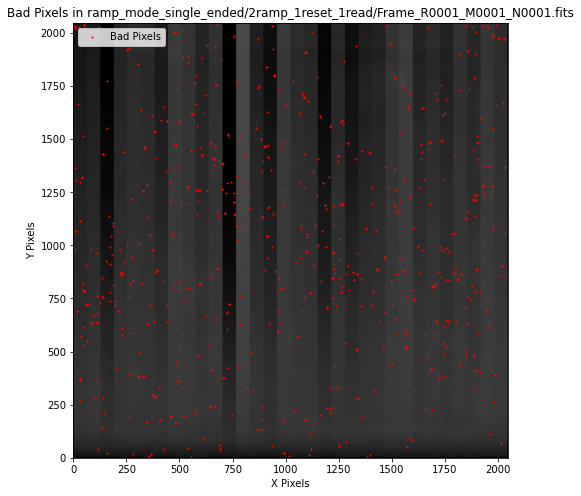

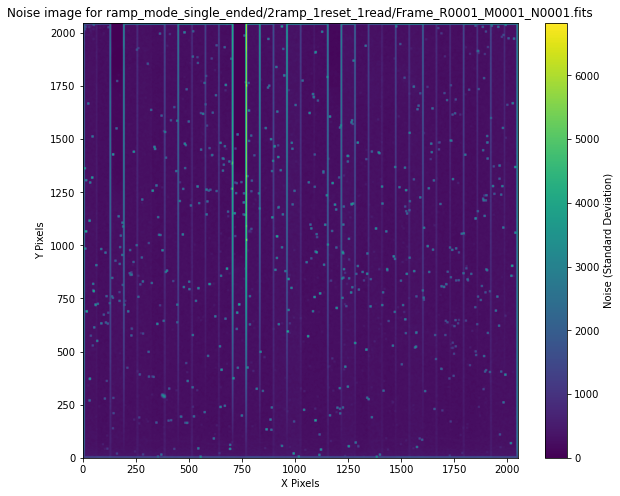

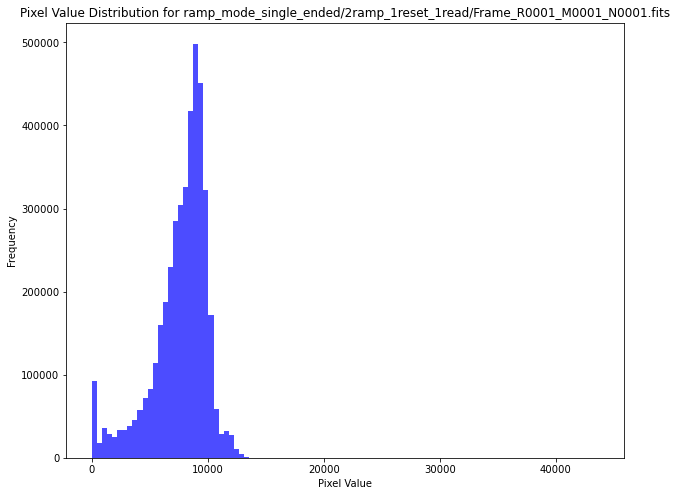

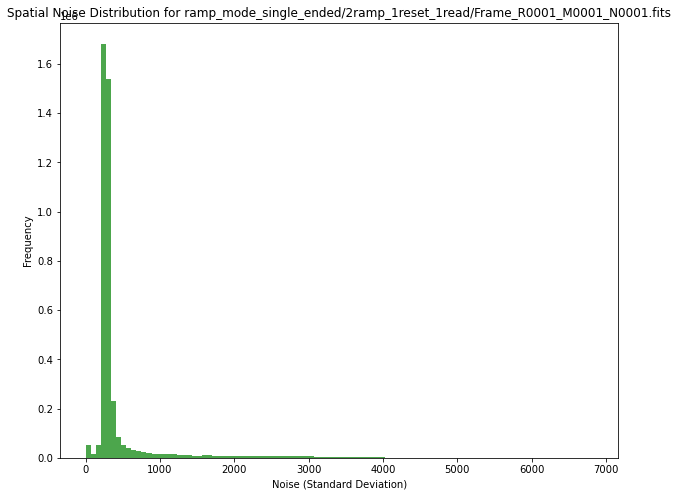

Number of bad pixels in ramp_mode_single_ended/2ramp_1reset_1read/Frame_R0002_M0001_N0001.fits: 760
Coordinates of bad pixels in ramp_mode_single_ended/2ramp_1reset_1read/Frame_R0002_M0001_N0001.fits: [[   5  553]
 [   5 1382]
 [   6  352]
 ...
 [2039   49]
 [2042   49]
 [2043  678]]


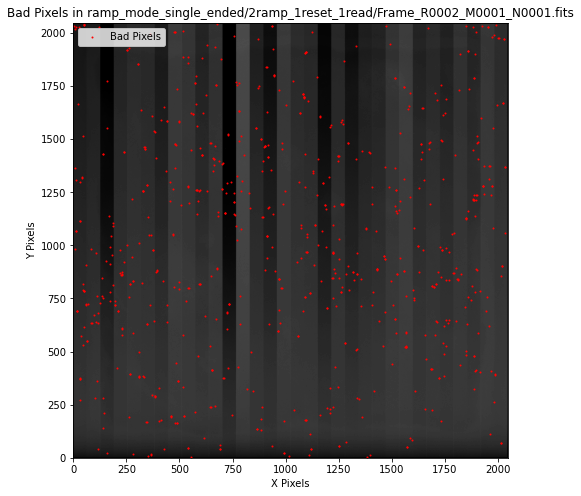

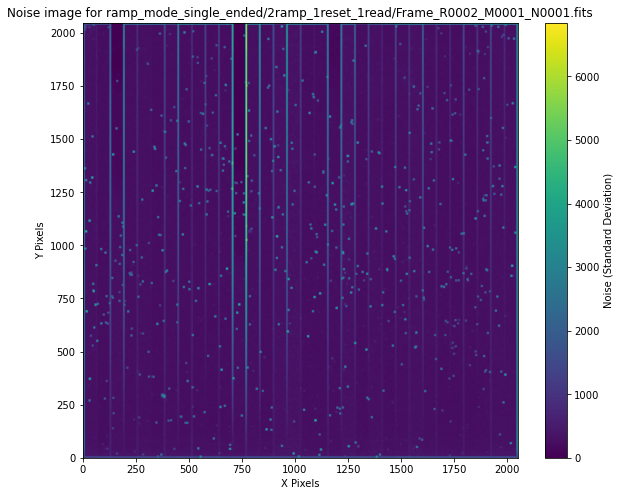

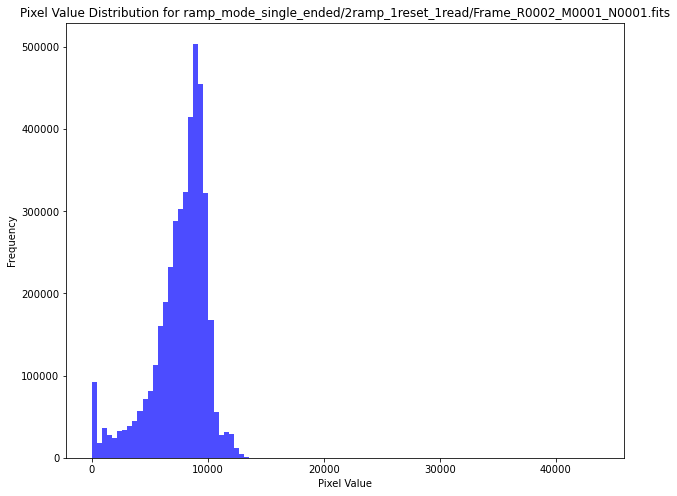

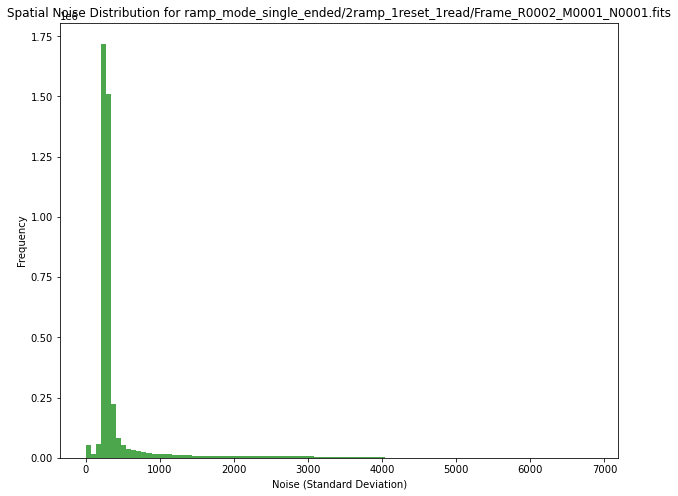

In [4]:
# Define parameters
# Define a range of threshold factors to test
threshold_factors = [50]
neighborhood_size = 80  # Adjust this size
window_size = 10  # Adjust this size

# Process each image in the folder
fits_filenames = ["ramp_mode_single_ended/2ramp_1reset_1read/Frame_R0001_M0001_N0001.fits",
                  "ramp_mode_single_ended/2ramp_1reset_1read/Frame_R0002_M0001_N0001.fits"]

for factor in threshold_factors:
    print(f"Testing with threshold factor: {factor}")
    for fits_filename in fits_filenames:
        process_image(fits_filename, factor, neighborhood_size, window_size)

In [5]:
def calculate_temporal_noise(fits_filenames):
    # Read all FITS files and store the image data in a list
    image_data_list = []
    for fits_filename in fits_filenames:
        hdul = fits.open(fits_filename)
        image_data = hdul[0].data.astype(np.int32)
        hdul.close()
        image_data_list.append(image_data)
    
    # Stack the images along a new axis to create a 3D array (frames, height, width)
    stacked_images = np.stack(image_data_list, axis=0)
    
    # Calculate the standard deviation along the time axis (axis=0) to get temporal noise
    temporal_noise = np.std(stacked_images, axis=0)
    
    return temporal_noise

In [6]:
# Define the folder and FITS filenames
folder = "ramp_mode_single_ended/2ramp_1reset_2read"
fits_filenames = [os.path.join(folder, f"Frame_R0001_M0001_N0001.fits"),
                  os.path.join(folder, f"Frame_R0001_M0001_N0002.fits"),
                  os.path.join(folder, f"Frame_R0002_M0001_N0001.fits"),
                  os.path.join(folder, f"Frame_R0002_M0001_N0002.fits")]

# Calculate temporal noise
temporal_noise = calculate_temporal_noise(fits_filenames)

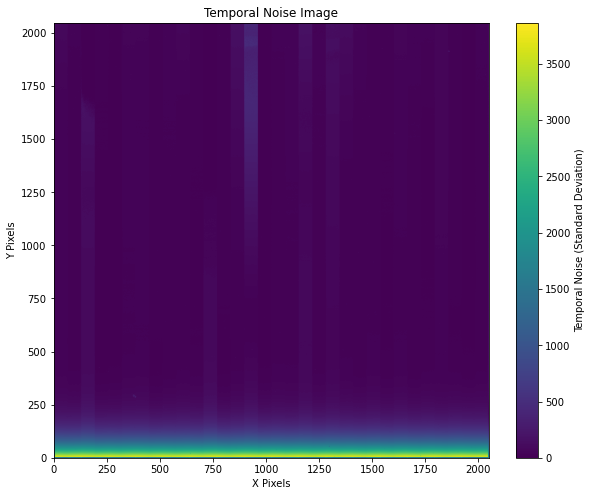

In [7]:
# Plot the temporal noise image
plt.figure(figsize=(10, 8))
plt.imshow(temporal_noise, cmap='viridis', origin='lower')
plt.colorbar(label='Temporal Noise (Standard Deviation)')
plt.title('Temporal Noise Image')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

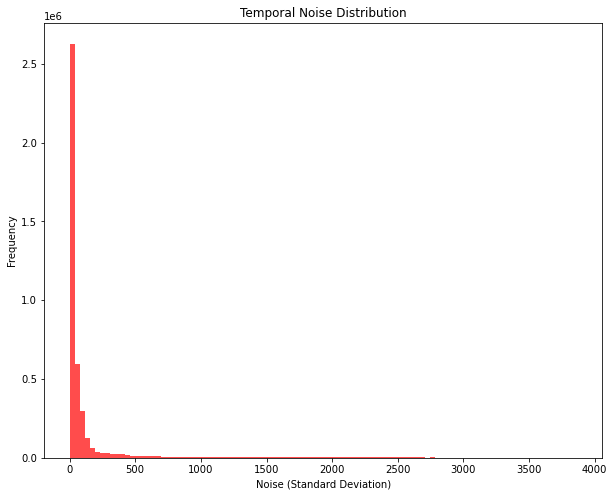

In [8]:
# Histogram of temporal noise
plt.figure(figsize=(10, 8))
plt.hist(temporal_noise.flatten(), bins=100, color='red', alpha=0.7)
plt.title('Temporal Noise Distribution')
plt.xlabel('Noise (Standard Deviation)')
plt.ylabel('Frequency')
plt.show()

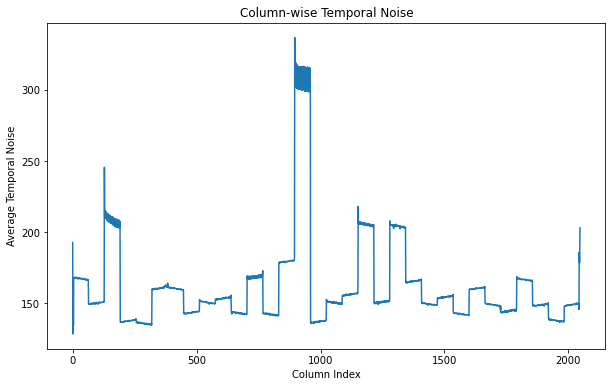

In [22]:
column_noise = np.mean(temporal_noise, axis=0)
plt.figure(figsize=(10, 6))
plt.plot(column_noise)
plt.xlabel('Column Index')
plt.ylabel('Average Temporal Noise')
plt.title('Column-wise Temporal Noise')
plt.show()


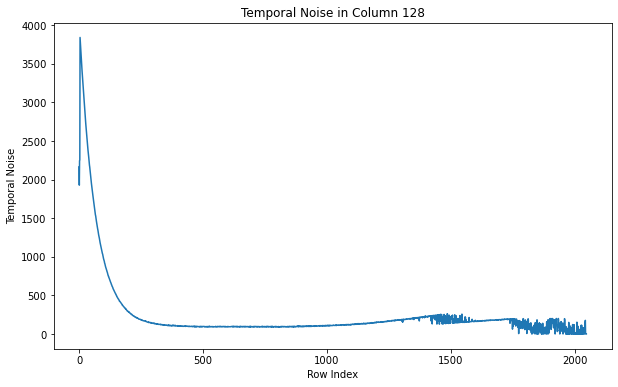

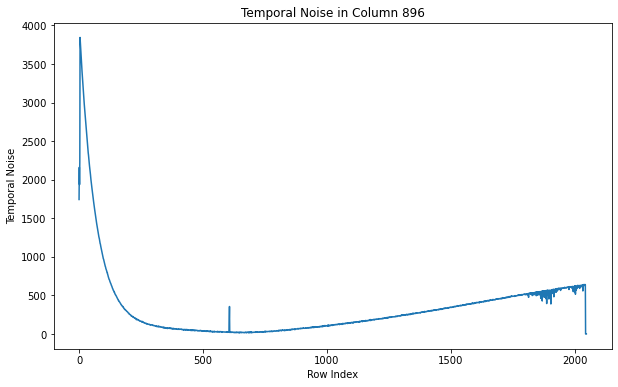

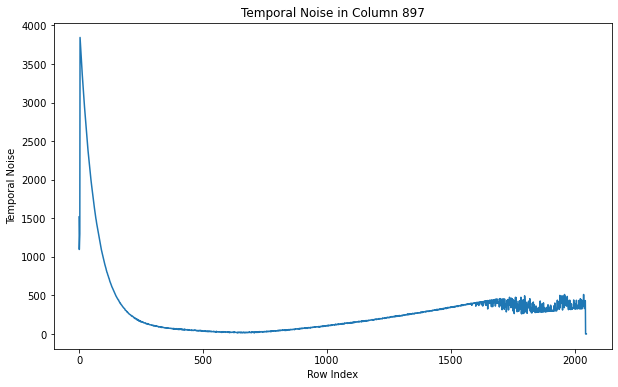

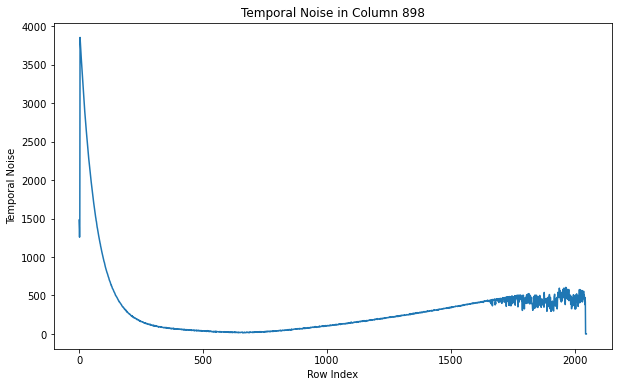

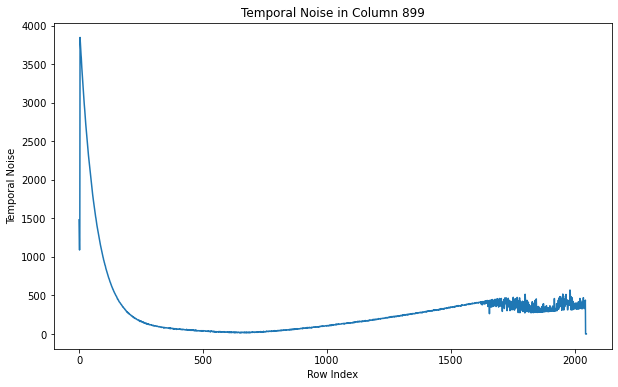

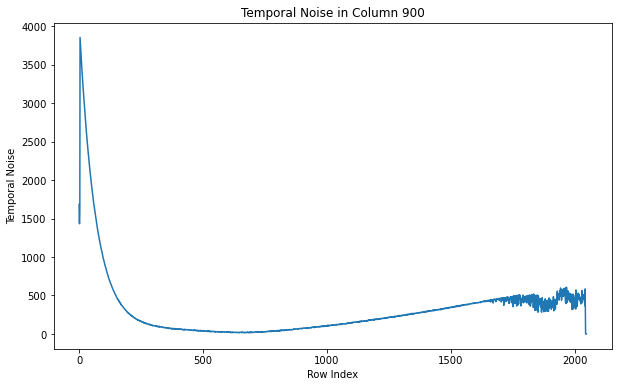

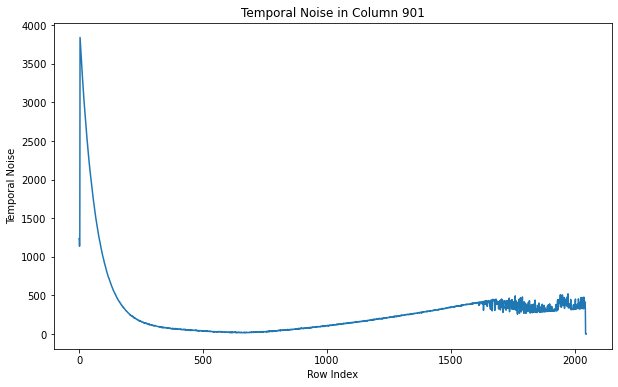

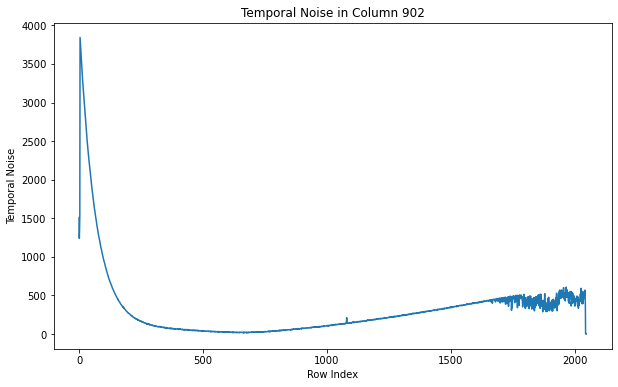

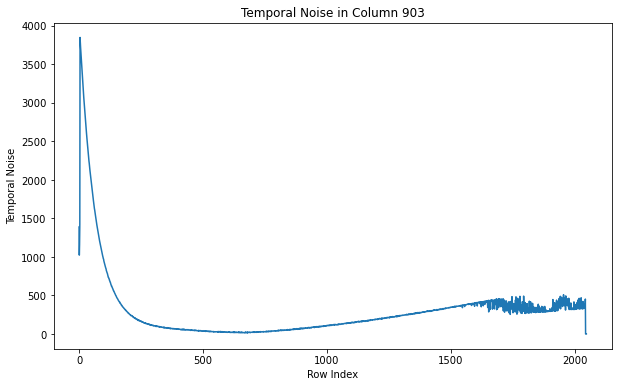

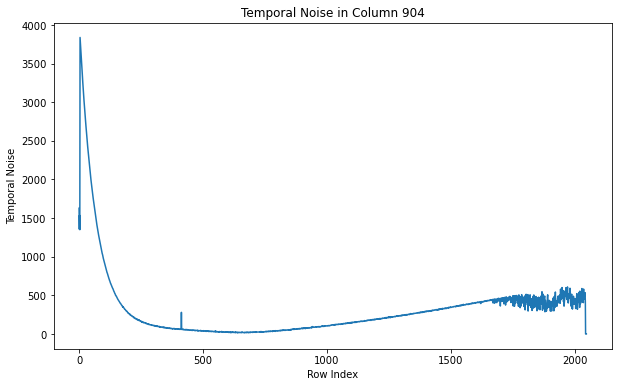

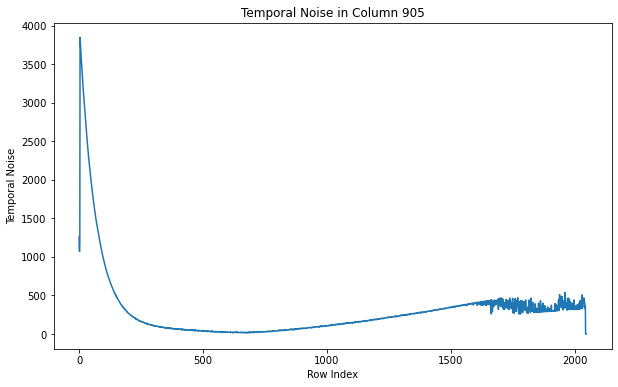

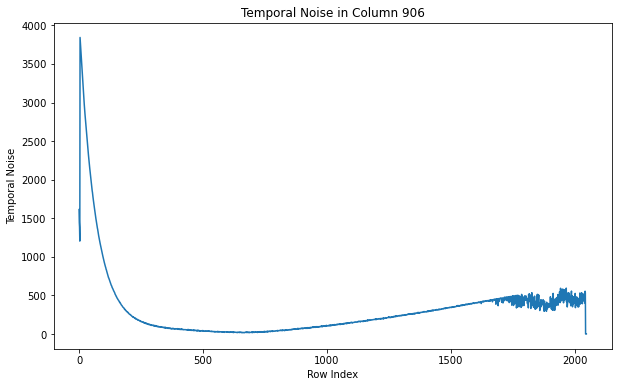

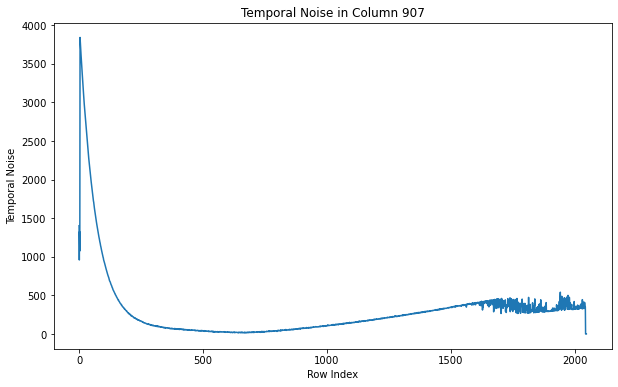

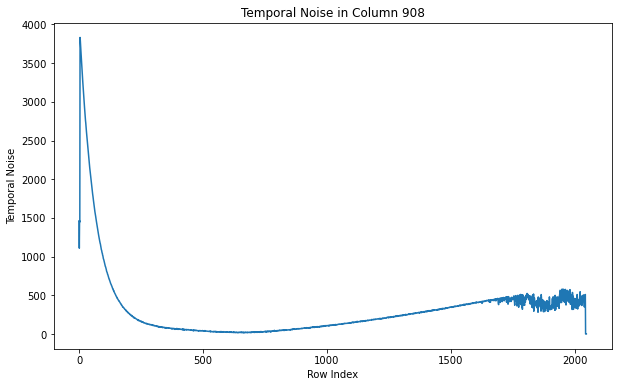

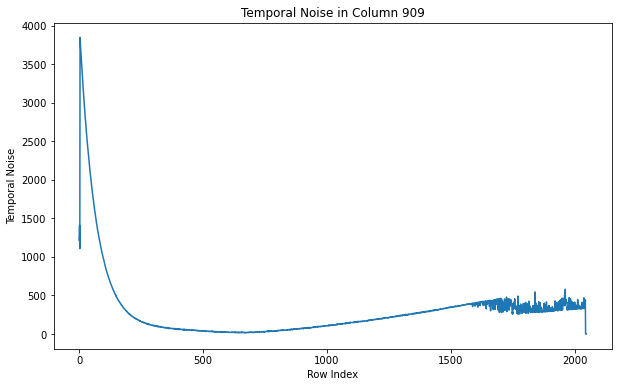

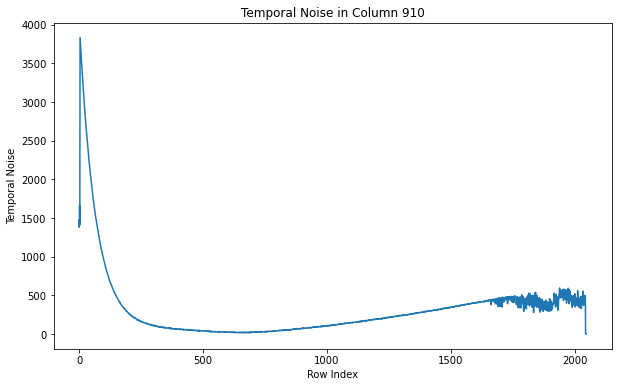

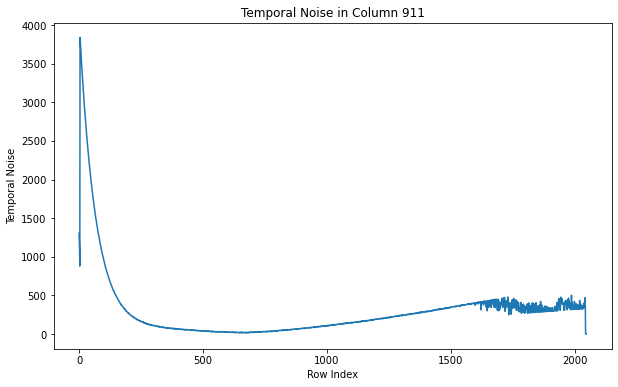

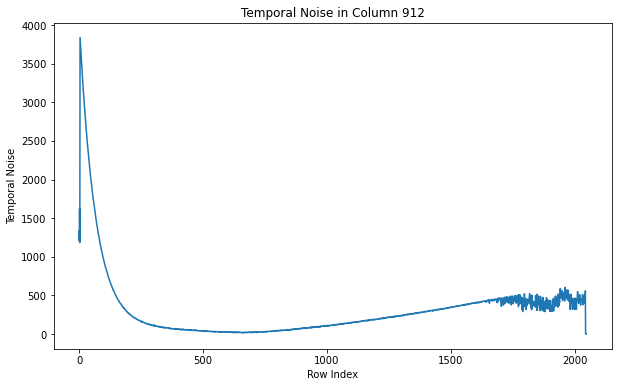

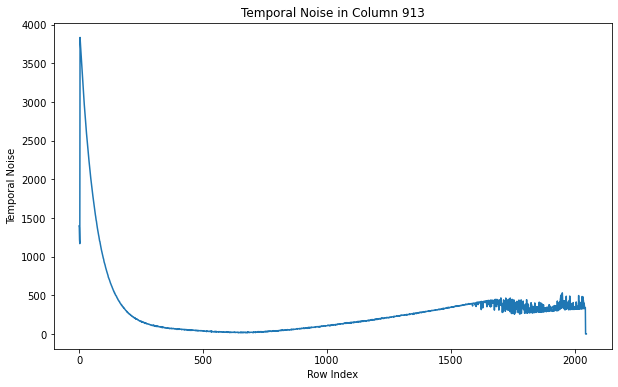

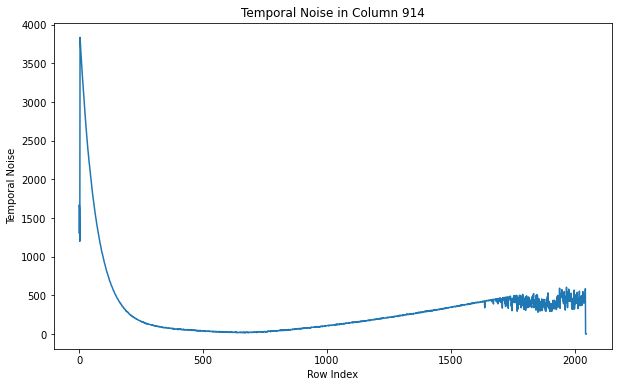

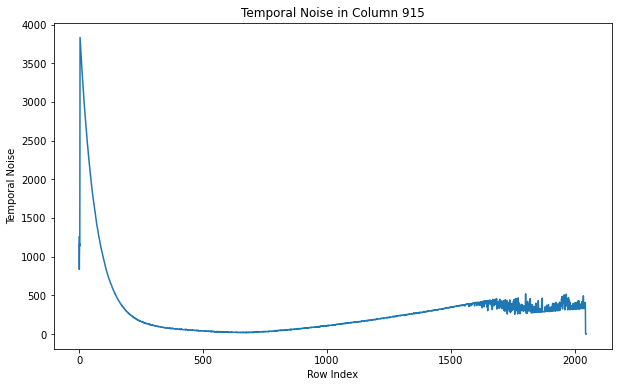

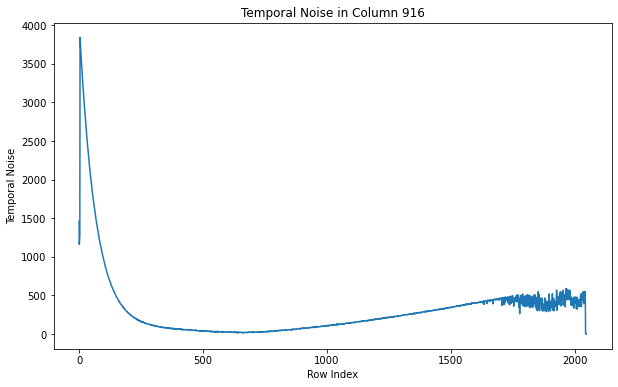

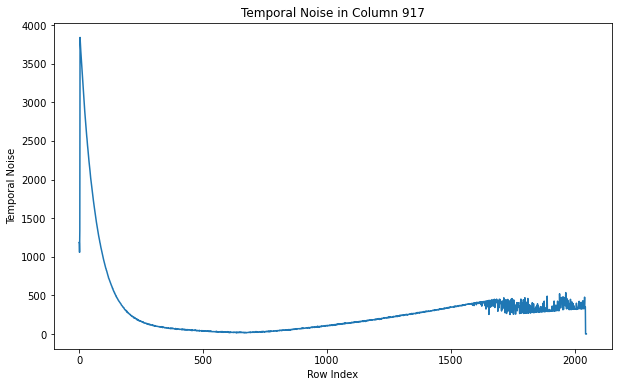

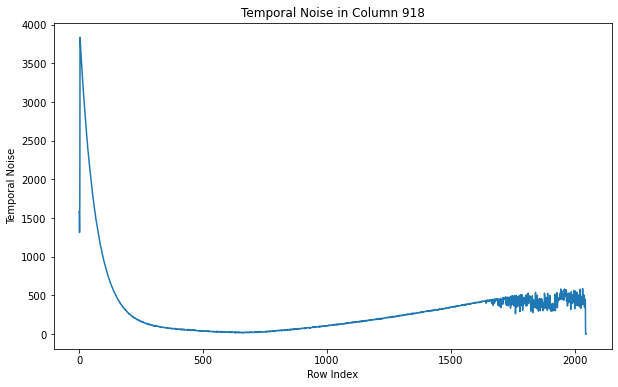

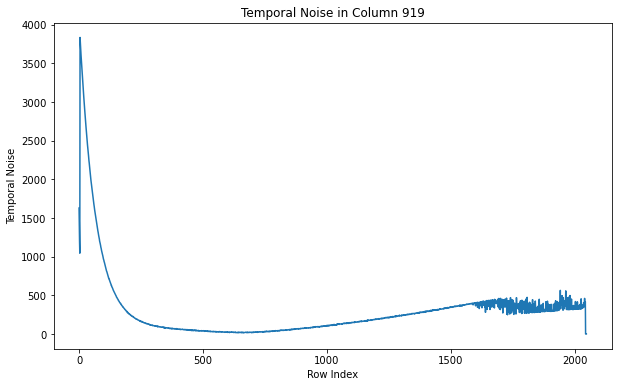

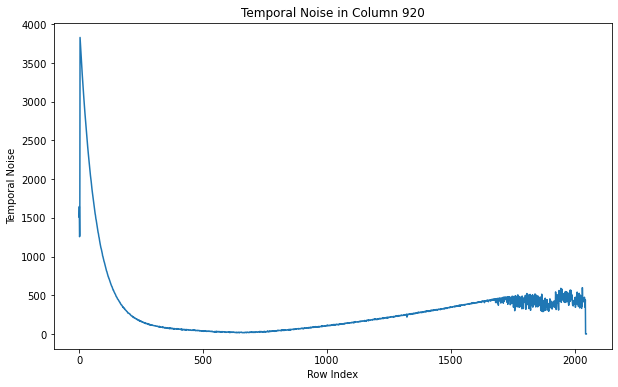

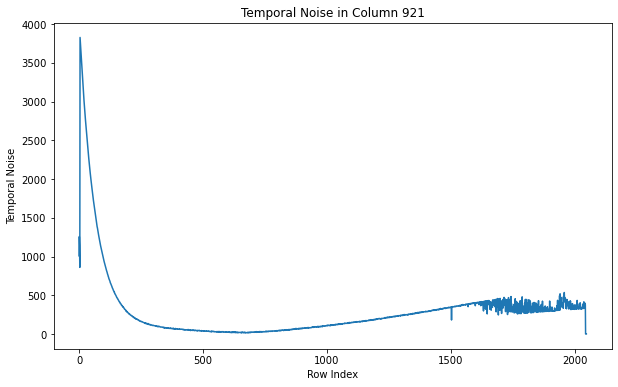

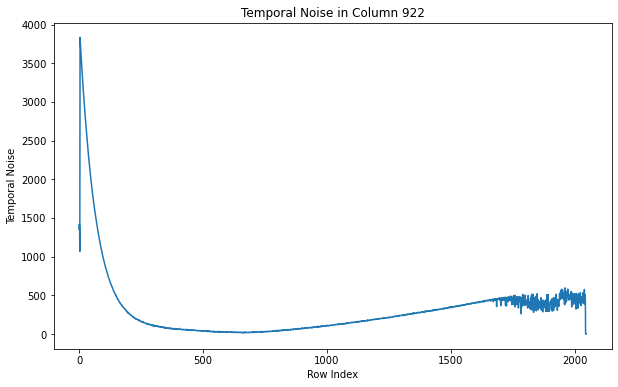

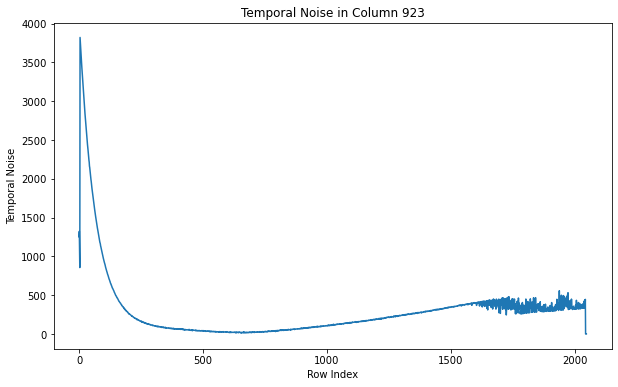

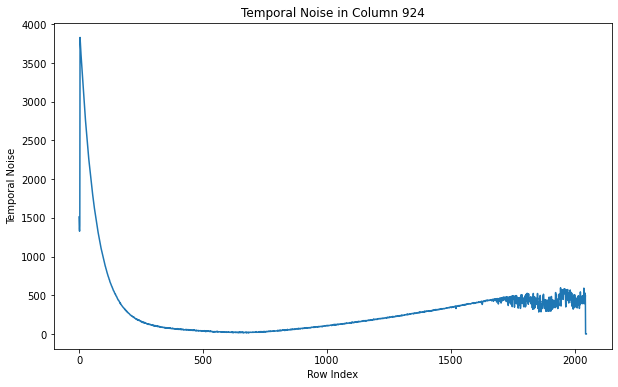

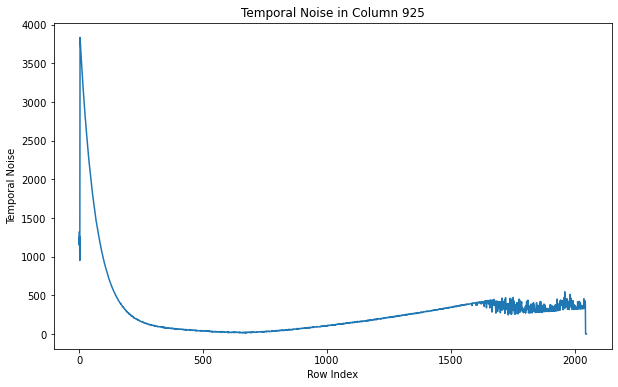

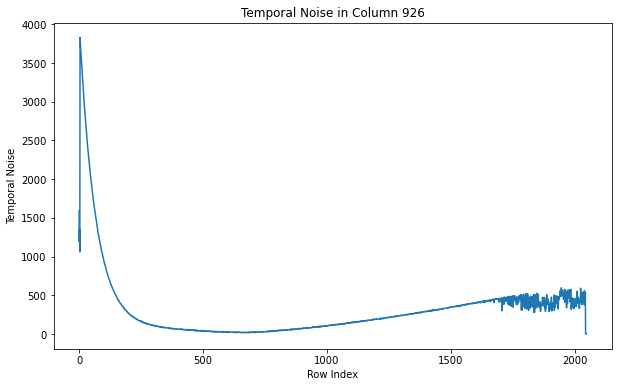

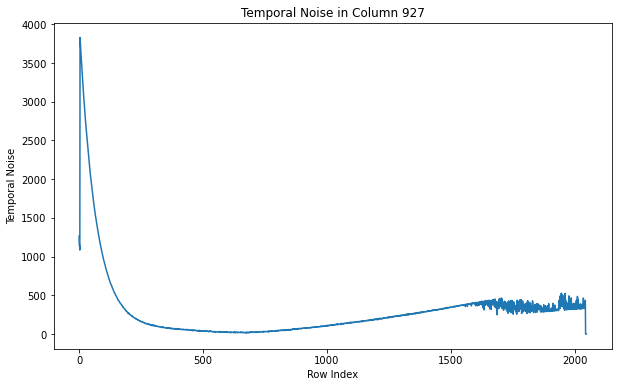

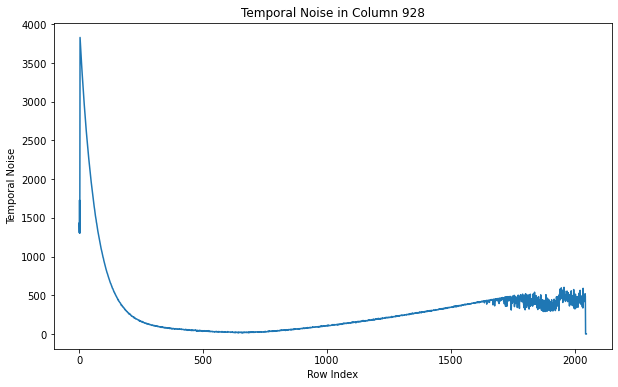

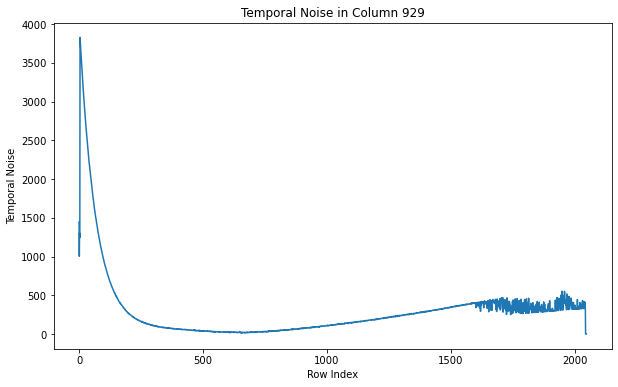

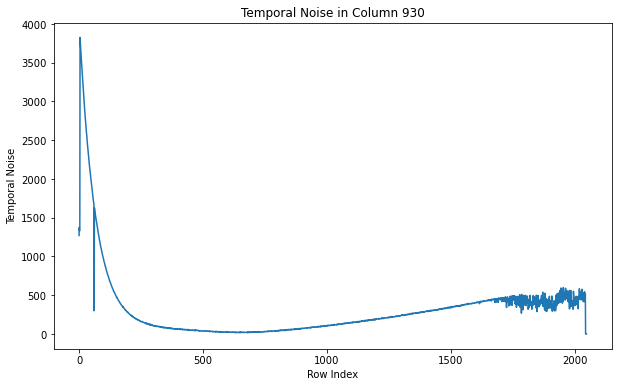

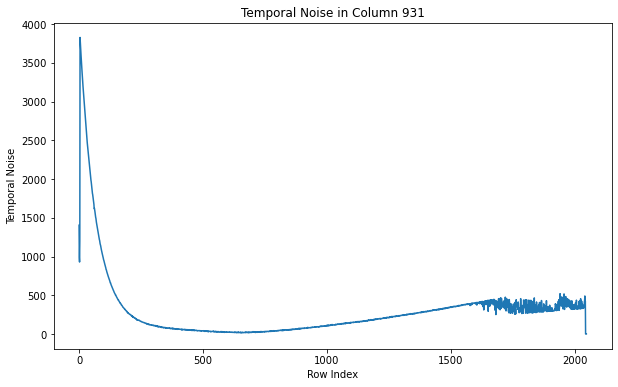

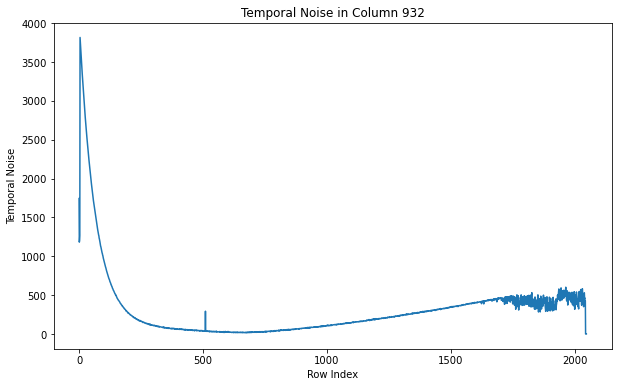

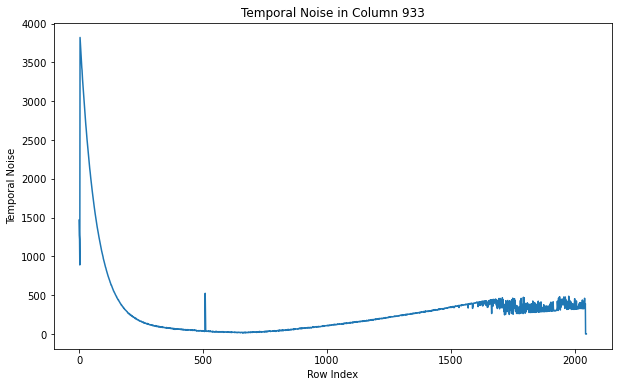

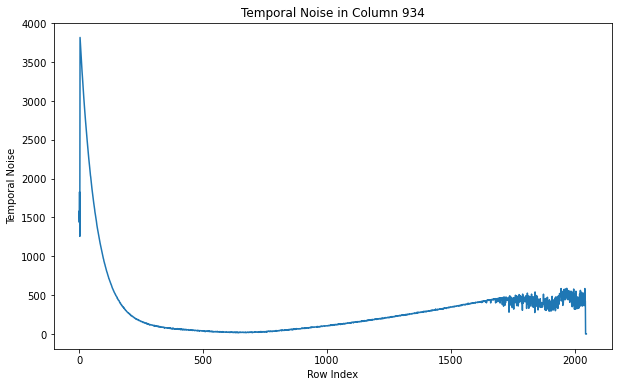

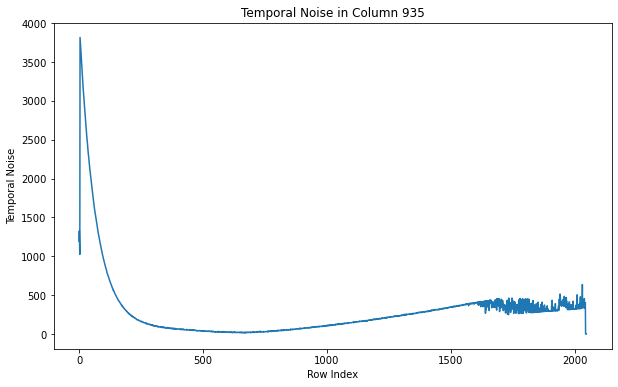

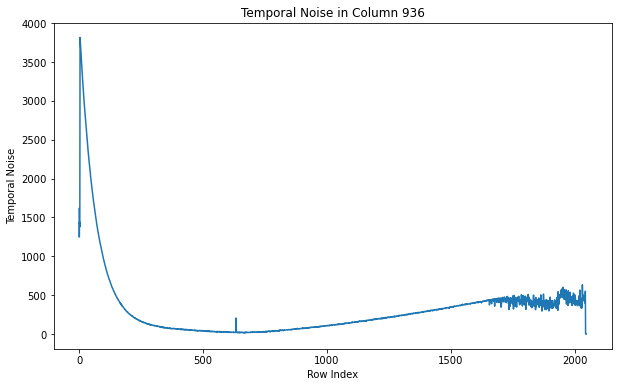

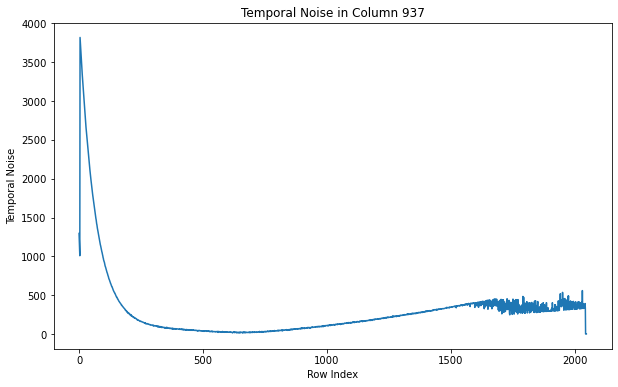

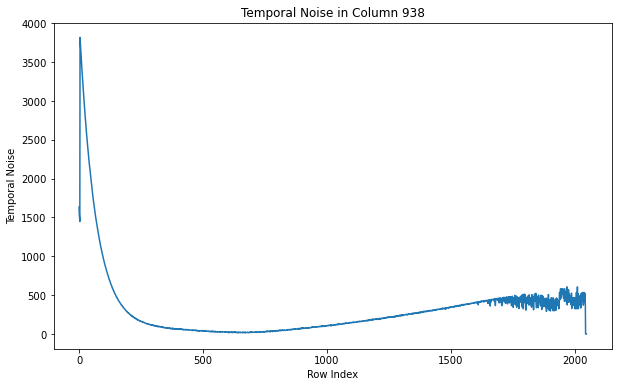

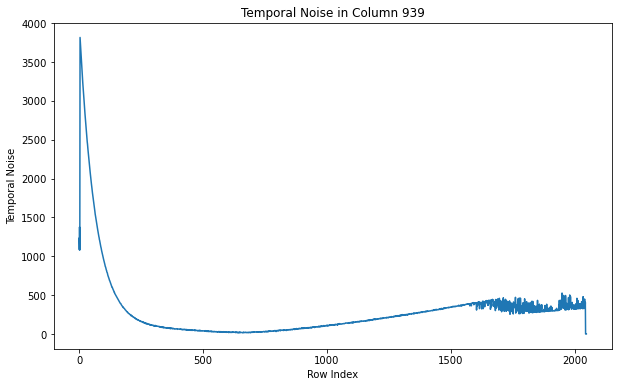

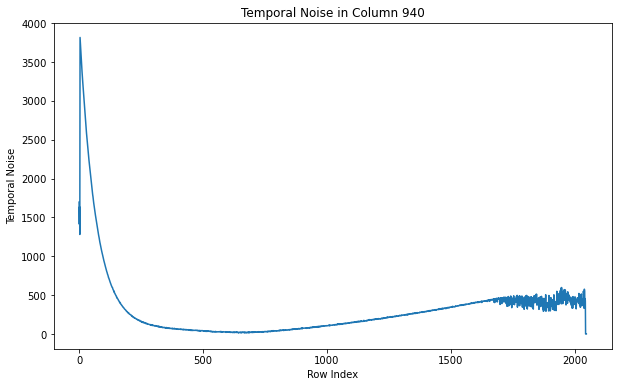

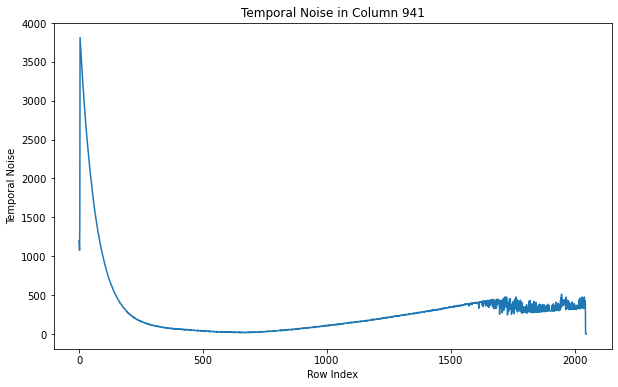

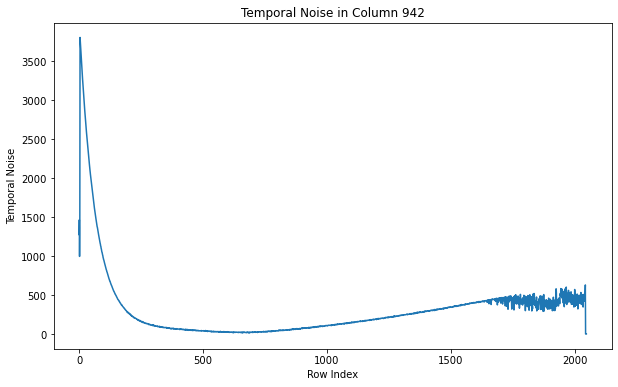

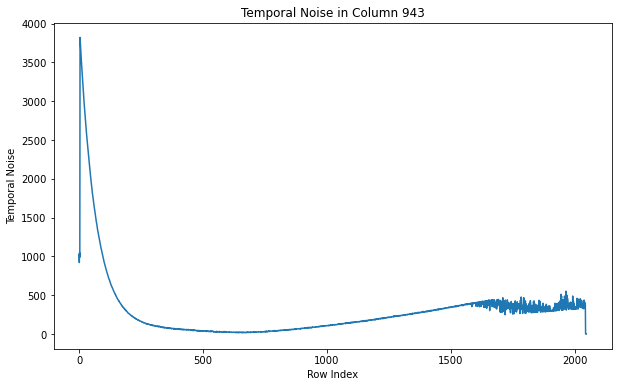

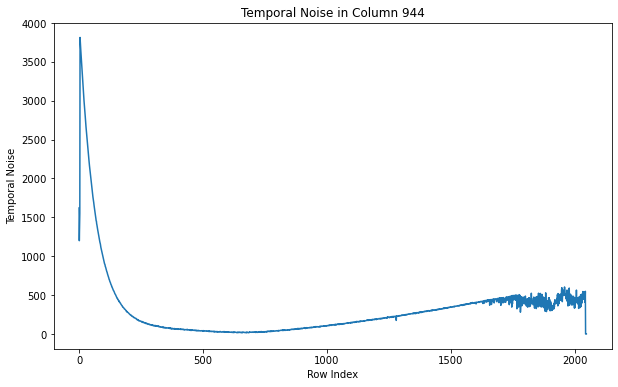

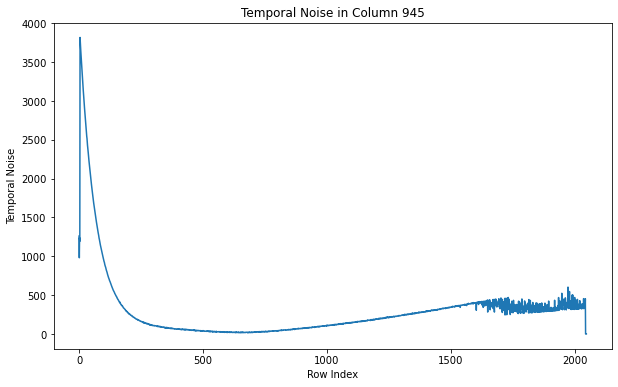

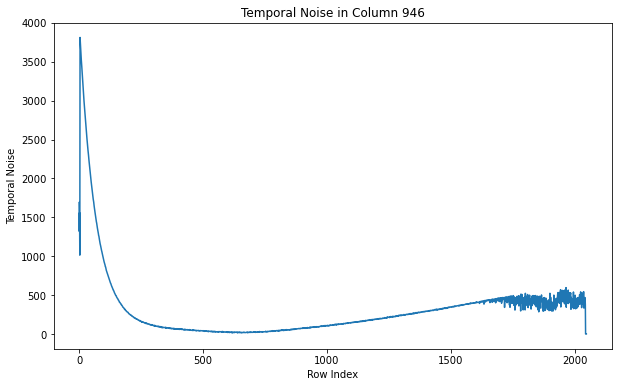

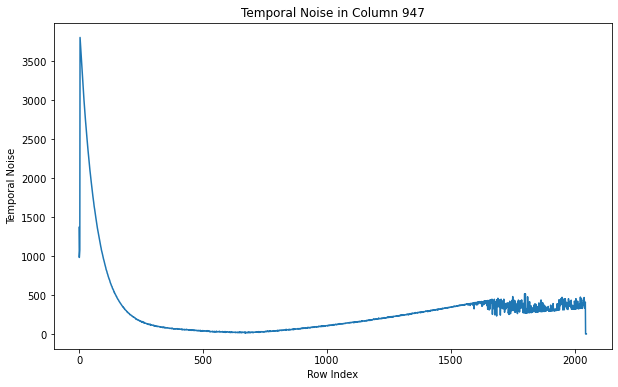

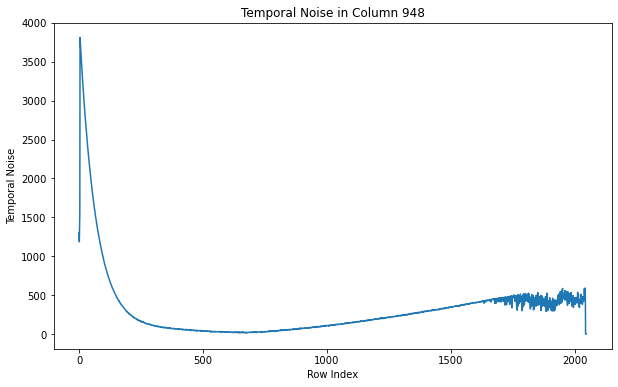

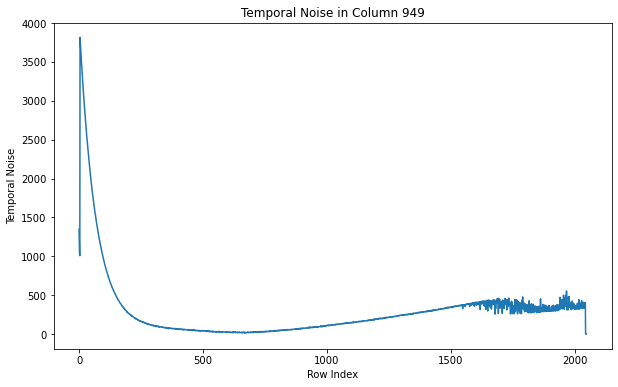

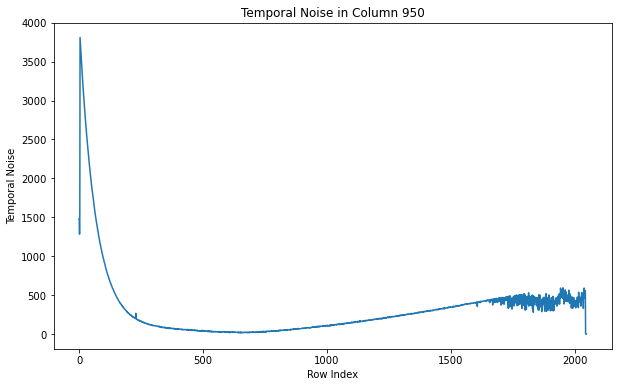

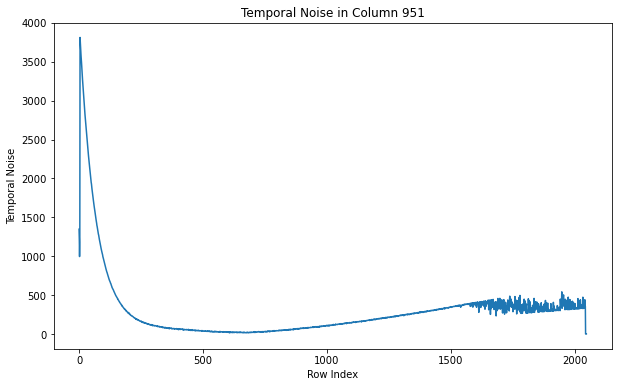

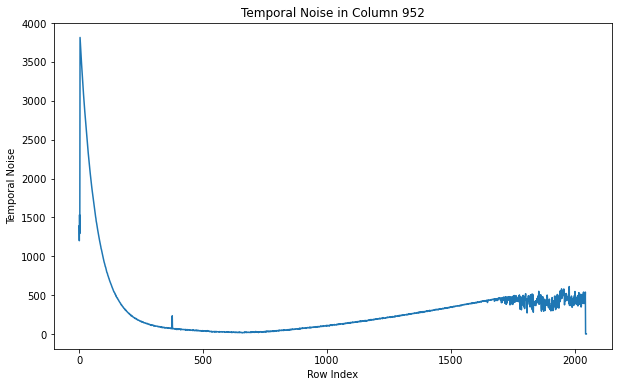

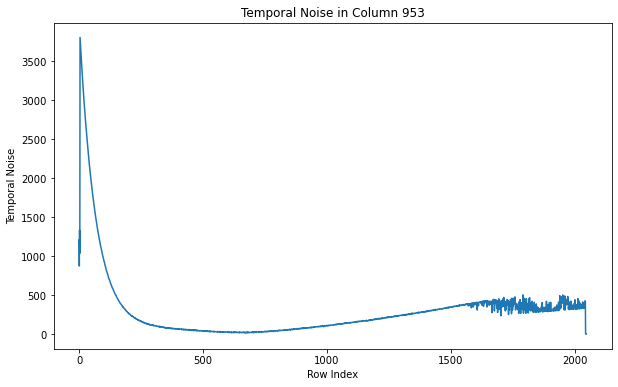

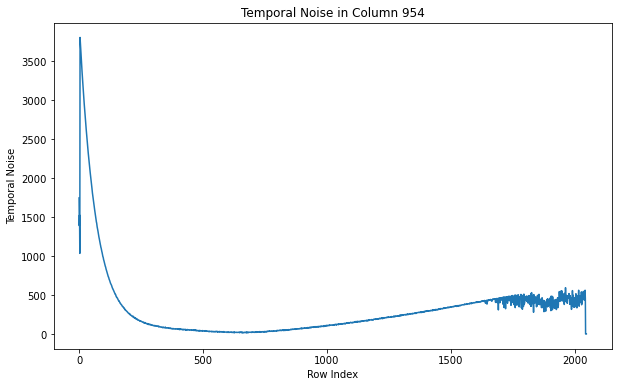

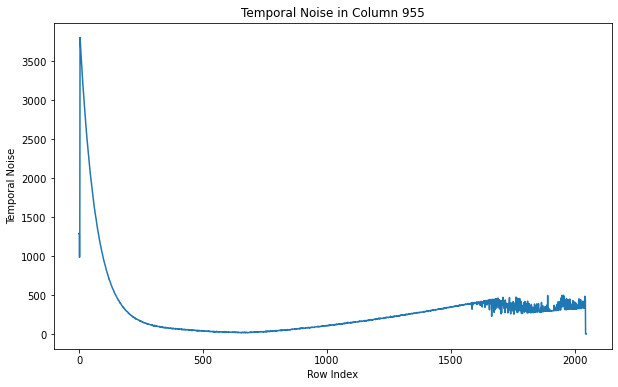

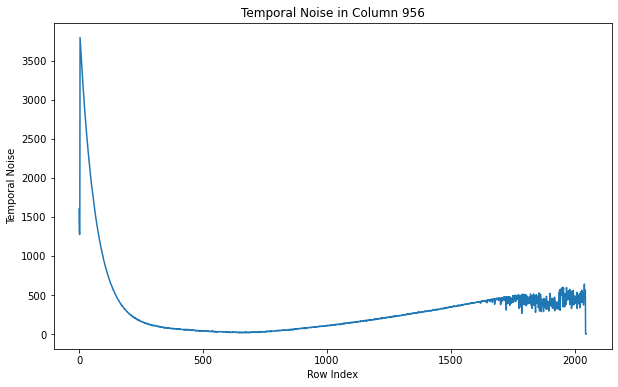

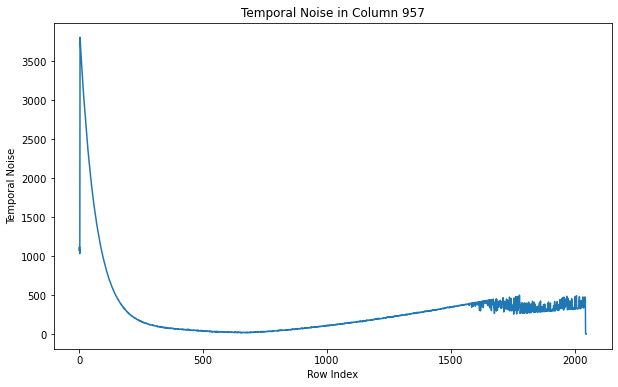

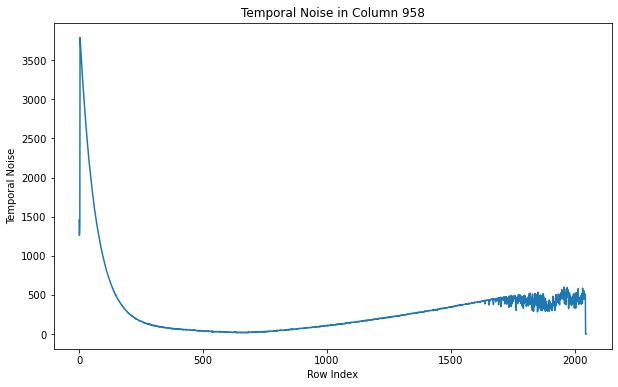

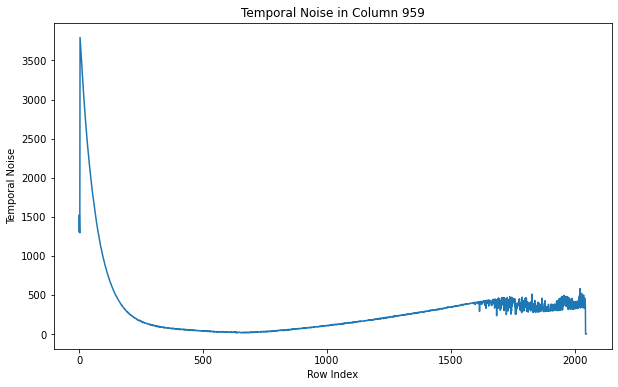

In [23]:
high_noise_columns = np.where(column_noise > np.mean(column_noise) + 2 * np.std(column_noise))[0]
for col in high_noise_columns:
    plt.figure(figsize=(10, 6))
    plt.plot(temporal_noise[:, col])
    plt.xlabel('Row Index')
    plt.ylabel('Temporal Noise')
    plt.title(f'Temporal Noise in Column {col}')
    plt.show()


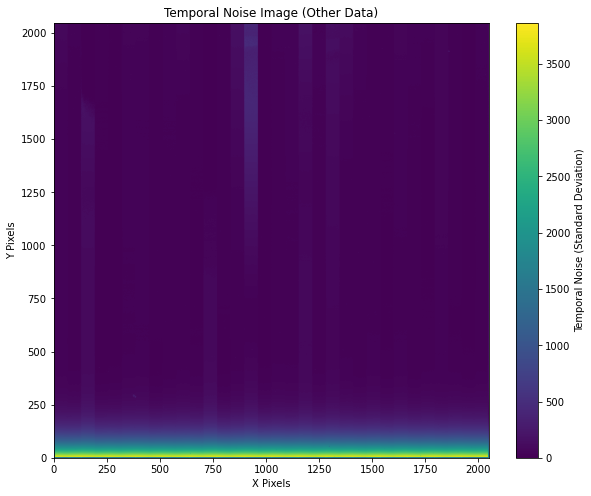

In [25]:
# Assuming you have another set of FITS files for comparison

folder1 = "ramp_mode_single_ended/2ramp_2read_2reset"
other_fits_filenames = [os.path.join(folder, f"Frame_R0001_M0001_N0001.fits"),
                  os.path.join(folder, f"Frame_R0001_M0001_N0002.fits"),
                  os.path.join(folder, f"Frame_R0002_M0001_N0001.fits"),
                  os.path.join(folder, f"Frame_R0002_M0001_N0002.fits")]

other_temporal_noise = calculate_temporal_noise(other_fits_filenames)

# Plot comparison
plt.figure(figsize=(10, 8))
plt.imshow(other_temporal_noise, cmap='viridis', origin='lower')
plt.colorbar(label='Temporal Noise (Standard Deviation)')
plt.title('Temporal Noise Image (Other Data)')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()


In [19]:
import numpy as np
from astropy.io import fits
from scipy.ndimage import gaussian_filter, generic_filter
import matplotlib.pyplot as plt
import os

def count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size):
    # Calculate local mean and standard deviation for each pixel
    local_mean = gaussian_filter(image_data, sigma=neighborhood_size)
    local_std = np.sqrt(gaussian_filter((image_data - local_mean)**2, sigma=neighborhood_size))

    # Define threshold based on local statistics
    threshold = local_mean + threshold_factor * local_std

    # Identify bad pixels based on thresholding
    bad_pixel_mask = image_data > threshold

    # Get coordinates of bad pixels
    bad_pixel_coords = np.argwhere(bad_pixel_mask)
    num_bad_pixels = len(bad_pixel_coords)

    return num_bad_pixels, bad_pixel_coords, bad_pixel_mask

def process_image(fits_filename, threshold_factor, neighborhood_size, window_size):
    hdul = fits.open(fits_filename)
    image_data = hdul[0].data
    hdul.close()
    num_bad_pixels, bad_pixel_coords, bad_pixel_mask = count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size)
    print(f"Number of bad pixels in {fits_filename}:", num_bad_pixels)
    print(f"Coordinates of bad pixels in {fits_filename}:", bad_pixel_coords)
    plt.figure(figsize=(10, 8))
    plt.imshow(image_data, cmap='gray', origin='lower')
    plt.scatter(bad_pixel_coords[:, 1], bad_pixel_coords[:, 0], color='red', s=1, label='Bad Pixels')
    plt.colorbar(label='Pixel Value')
    plt.title(f'Bad Pixels in {fits_filename}')
    plt.xlabel('X Pixels')
    plt.ylabel('Y Pixels')
    plt.legend()
    plt.show()
    noise_image = generic_filter(image_data, np.std, size=window_size)
    return image_data, bad_pixel_mask, noise_image

def calculate_temporal_noise(fits_filenames):
    image_data_list = []
    for fits_filename in fits_filenames:
        hdul = fits.open(fits_filename)
        image_data = hdul[0].data.astype(np.int32)
        hdul.close()
        image_data_list.append(image_data)
    stacked_images = np.stack(image_data_list, axis=0)
    temporal_noise = np.std(stacked_images, axis=0)
    return temporal_noise

def combine_results(bad_pixel_mask, spatial_noise, temporal_noise):
    spatial_noise_norm = (spatial_noise - np.min(spatial_noise)) / (np.max(spatial_noise) - np.min(spatial_noise))
    temporal_noise_norm = (temporal_noise - np.min(temporal_noise)) / (np.max(temporal_noise) - np.min(temporal_noise))
    composite_image = np.zeros_like(spatial_noise_norm)
    composite_image[bad_pixel_mask] = 1
    composite_image += spatial_noise_norm
    composite_image += temporal_noise_norm
    return composite_image

Number of bad pixels in ramp_mode_single_ended/2ramp_1reset_1read/Frame_R0001_M0001_N0001.fits: 764
Coordinates of bad pixels in ramp_mode_single_ended/2ramp_1reset_1read/Frame_R0001_M0001_N0001.fits: [[   5  553]
 [   5 1382]
 [   6  352]
 ...
 [2039   49]
 [2042   49]
 [2043  678]]


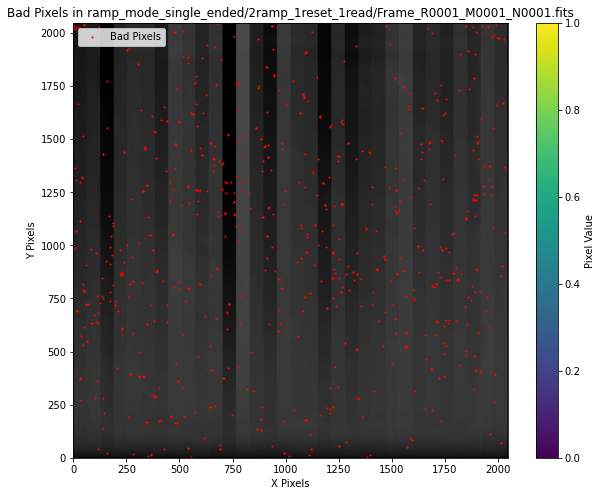

Number of bad pixels in ramp_mode_single_ended/2ramp_1reset_1read/Frame_R0002_M0001_N0001.fits: 764
Coordinates of bad pixels in ramp_mode_single_ended/2ramp_1reset_1read/Frame_R0002_M0001_N0001.fits: [[   5  553]
 [   5 1382]
 [   6  352]
 ...
 [2039   49]
 [2042   49]
 [2043  678]]


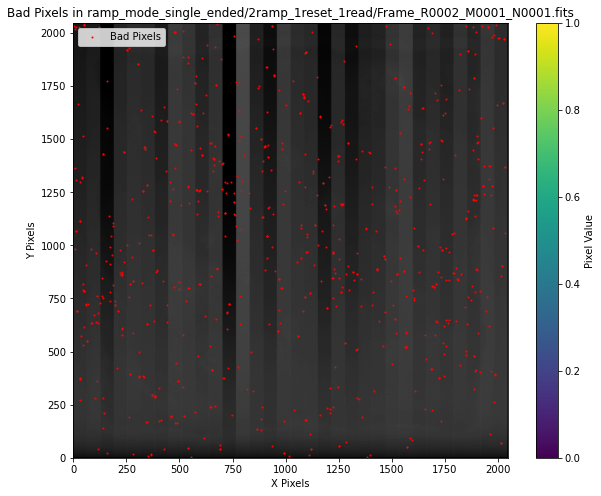

In [20]:
# Define parameters
threshold_factor = 50
neighborhood_size = 50
window_size = 10

# Process each image in the folder for bad pixels and spatial noise
fits_filenames_2ramp_1reset_1read = ["ramp_mode_single_ended/2ramp_1reset_1read/Frame_R0001_M0001_N0001.fits",
                                     "ramp_mode_single_ended/2ramp_1reset_1read/Frame_R0002_M0001_N0001.fits"]

image_data_list = []
bad_pixel_masks = []
spatial_noises = []

for fits_filename in fits_filenames_2ramp_1reset_1read:
    image_data, bad_pixel_mask, spatial_noise = process_image(fits_filename, threshold_factor, neighborhood_size, window_size)
    image_data_list.append(image_data)
    bad_pixel_masks.append(bad_pixel_mask)
    spatial_noises.append(spatial_noise)

combined_bad_pixel_mask = np.mean(bad_pixel_masks, axis=0) > 0.5
combined_spatial_noise = np.mean(spatial_noises, axis=0)

In [21]:
# Define the folder and FITS filenames for temporal noise calculation
folder_2ramp_1reset_2read = "ramp_mode_single_ended/2ramp_1reset_2read"
fits_filenames_2ramp_1reset_2read = [os.path.join(folder_2ramp_1reset_2read, f"Frame_R0001_M0001_N0001.fits"),
                                     os.path.join(folder_2ramp_1reset_2read, f"Frame_R0001_M0001_N0002.fits"),
                                     os.path.join(folder_2ramp_1reset_2read, f"Frame_R0002_M0001_N0001.fits"),
                                     os.path.join(folder_2ramp_1reset_2read, f"Frame_R0002_M0001_N0002.fits")]

# Calculate temporal noise
temporal_noise = calculate_temporal_noise(fits_filenames_2ramp_1reset_2read)

# Combine all results to identify the best region
composite_image = combine_results(combined_bad_pixel_mask, combined_spatial_noise, temporal_noise)

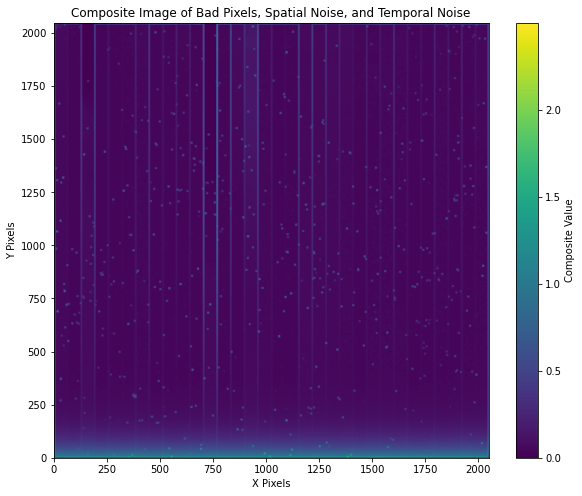

In [22]:
# Plot the composite image
plt.figure(figsize=(10, 8))
plt.imshow(composite_image, cmap='viridis', origin='lower')
plt.colorbar(label='Composite Value')
plt.title('Composite Image of Bad Pixels, Spatial Noise, and Temporal Noise')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

## 1 Ramp analysis  

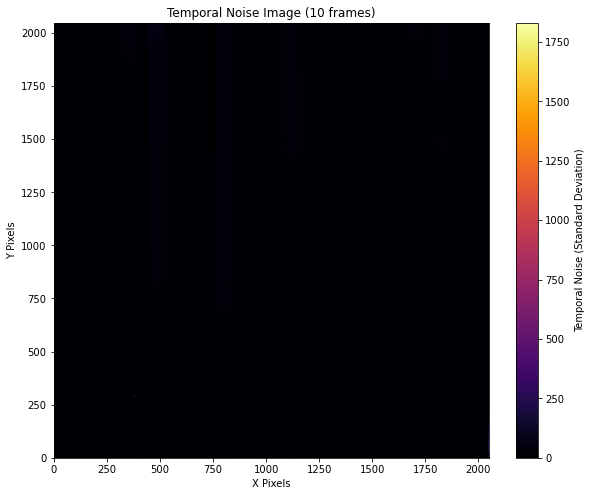

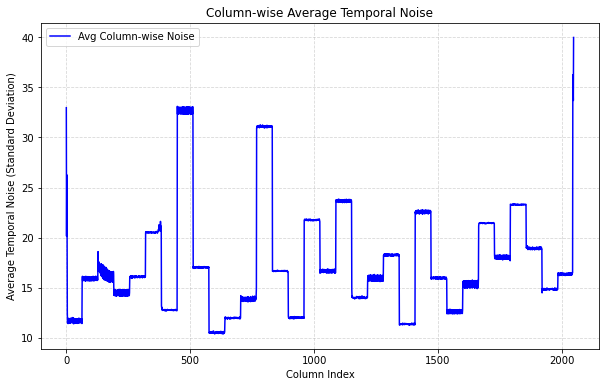

In [4]:
filenames = [f'ramp_mode_single_ended/10ramp_1reset_1read/Frame_R{i+1:04d}_M0001_N0001.fits' for i in range(10)]
images = [fits.open(filename)[0].data for filename in filenames]

# Stack the images along a new axis (time axis)
image_stack = np.stack(images, axis=-1)

# Step 2: Calculate the temporal noise (standard deviation across the time axis)
temporal_noise = np.std(image_stack, axis=-1)

column_wise_noise = np.mean(temporal_noise, axis=0)

# temporal noise image
plt.figure(figsize=(10, 8))
plt.imshow(temporal_noise, cmap='inferno', origin='lower')
plt.colorbar(label='Temporal Noise (Standard Deviation)')
plt.title('Temporal Noise Image (10 frames)')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()
hdu = fits.PrimaryHDU(temporal_noise)
hdu.writeto('ramp_mode_single_ended/10ramp_1reset_1read/temporal_noise_image.fits', overwrite=True)

# average column-wise noise
plt.figure(figsize=(10, 6))
plt.plot(range(temporal_noise.shape[1]), column_wise_noise, color='b', label='Avg Column-wise Noise')
plt.xlabel('Column Index')
plt.ylabel('Average Temporal Noise (Standard Deviation)')
plt.title('Column-wise Average Temporal Noise')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

Testing with threshold factor: 10
Number of bad pixels in ramp_mode_single_ended/10ramp_1reset_1read/temporal_noise_image.fits: 115
Coordinates of bad pixels in ramp_mode_single_ended/10ramp_1reset_1read/temporal_noise_image.fits: [[   1  639]
 [   2  256]
 [   2  639]
 [   3  512]
 [   6 1321]
 [  55 1295]
 [  61  930]
 [  74  701]
 [  82 1521]
 [ 112  621]
 [ 113  381]
 [ 133  811]
 [ 141 1808]
 [ 153  629]
 [ 158 1809]
 [ 161  264]
 [ 167  497]
 [ 170 1759]
 [ 218  963]
 [ 220 1469]
 [ 227 1554]
 [ 231 1093]
 [ 248 1554]
 [ 251 1264]
 [ 283 1865]
 [ 286  383]
 [ 287  381]
 [ 287  384]
 [ 288  378]
 [ 289  387]
 [ 290  374]
 [ 290  375]
 [ 290  382]
 [ 291  378]
 [ 292  383]
 [ 293  375]
 [ 293  376]
 [ 294  377]
 [ 294  378]
 [ 295  374]
 [ 295  378]
 [ 295  380]
 [ 296  375]
 [ 297  372]
 [ 298  382]
 [ 323  682]
 [ 324  144]
 [ 334 1721]
 [ 341   24]
 [ 347  141]
 [ 354 1288]
 [ 376 1940]
 [ 416 1228]
 [ 416 1229]
 [ 425  212]
 [ 468 1173]
 [ 492  174]
 [ 583 1912]
 [ 594 1124]
 [

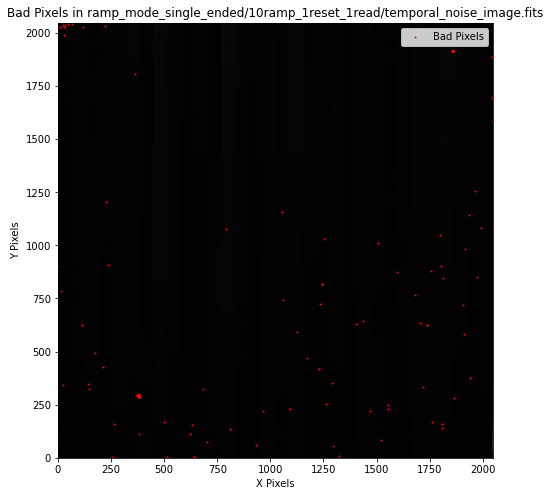

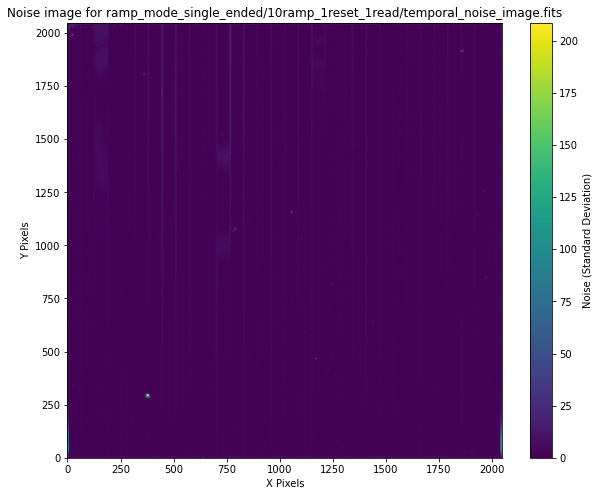

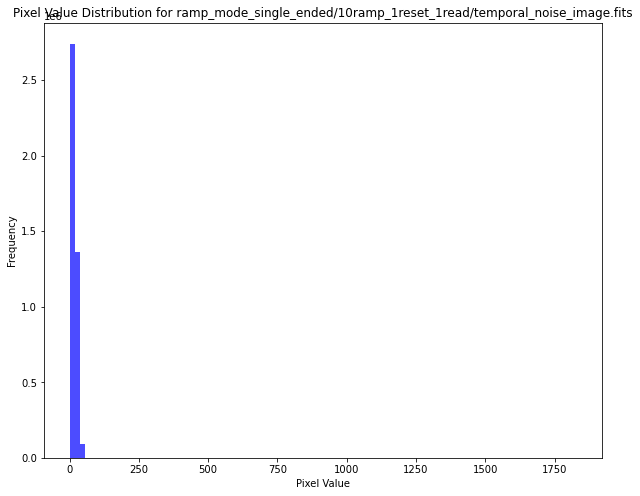

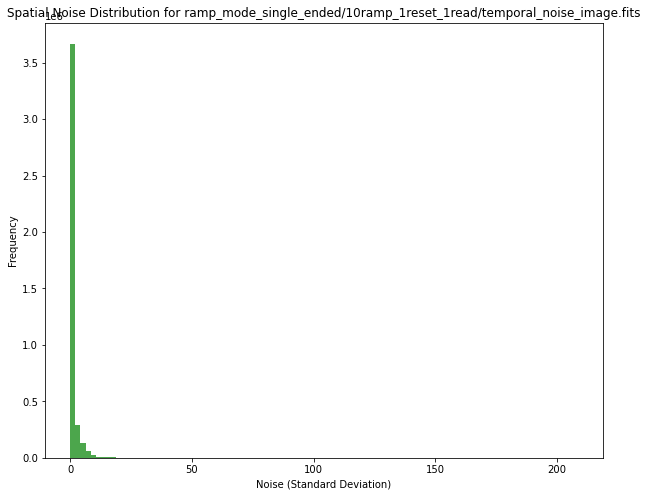

Testing with threshold factor: 20
Number of bad pixels in ramp_mode_single_ended/10ramp_1reset_1read/temporal_noise_image.fits: 25
Coordinates of bad pixels in ramp_mode_single_ended/10ramp_1reset_1read/temporal_noise_image.fits: [[   2  639]
 [ 286  383]
 [ 287  384]
 [ 290  374]
 [ 295  378]
 [ 295  380]
 [ 354 1288]
 [ 416 1228]
 [ 468 1173]
 [ 644 1438]
 [ 850 1971]
 [1078  792]
 [1145 1933]
 [1158 1056]
 [1257 1963]
 [1805  363]
 [1914 1858]
 [1914 1861]
 [1915 1856]
 [1915 1858]
 [1916 1859]
 [1916 1860]
 [1992   26]
 [2029   11]
 [2037   24]]


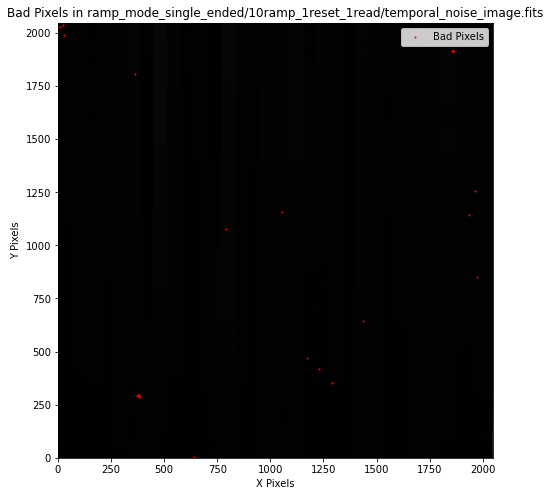

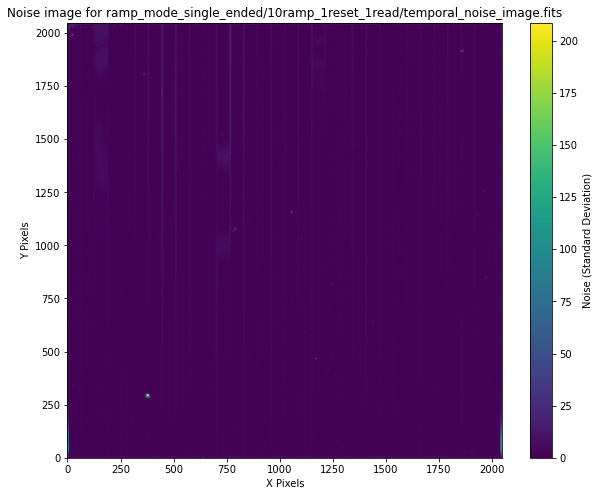

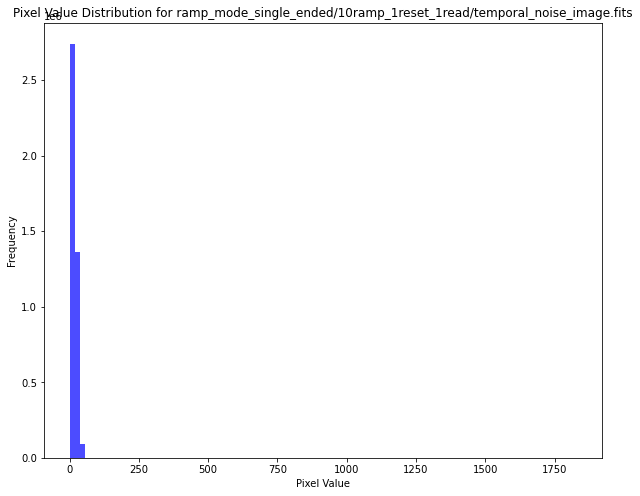

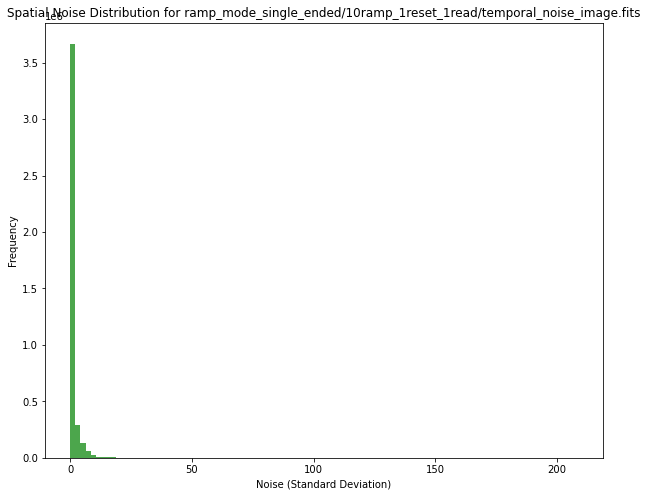

Testing with threshold factor: 30
Number of bad pixels in ramp_mode_single_ended/10ramp_1reset_1read/temporal_noise_image.fits: 12
Coordinates of bad pixels in ramp_mode_single_ended/10ramp_1reset_1read/temporal_noise_image.fits: [[   2  639]
 [ 290  374]
 [ 295  380]
 [ 468 1173]
 [ 850 1971]
 [1078  792]
 [1158 1056]
 [1257 1963]
 [1914 1861]
 [1915 1858]
 [1916 1859]
 [1992   26]]


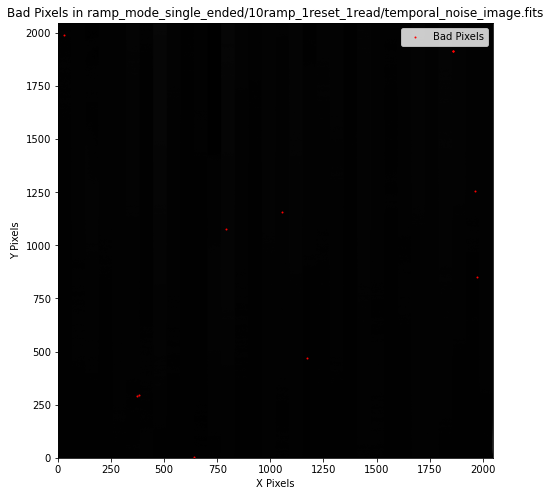

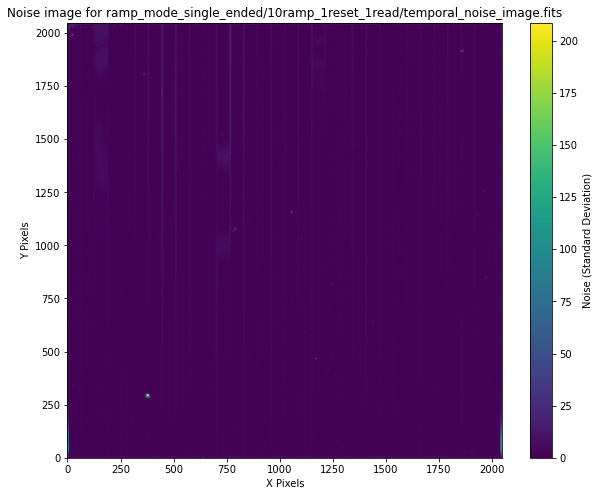

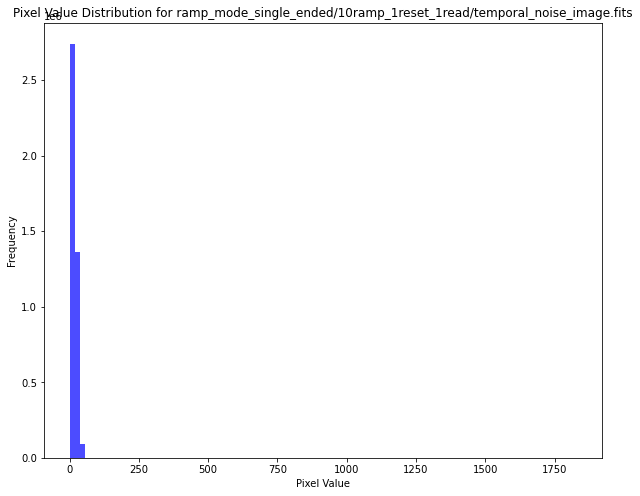

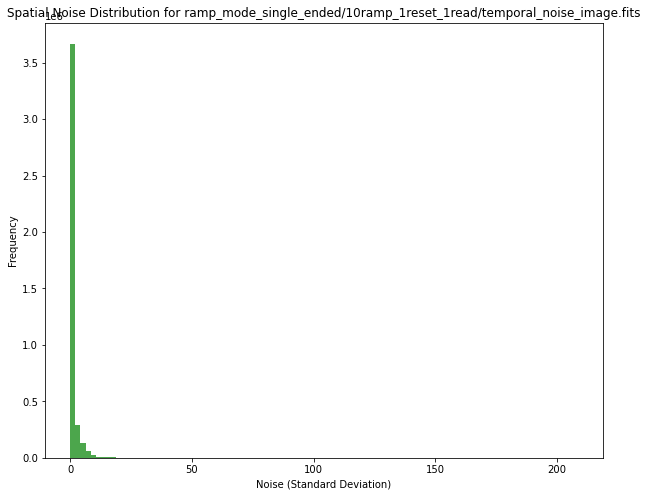

In [9]:
threshold_factors = [10,20,30]
neighborhood_size = 50  # Adjust this size
window_size = 10  # Adjust this size

# Process each image in the folder
fits_filenames = ["ramp_mode_single_ended/10ramp_1reset_1read/temporal_noise_image.fits"]

for factor in threshold_factors:
    print(f"Testing with threshold factor: {factor}")
    for fits_filename in fits_filenames:
        process_image(fits_filename, factor, neighborhood_size, window_size)

Number of bad pixels in ramp_mode_single_ended/10ramp_1reset_1read/Frame_R0010_M0001_N0001.fits: 771
Coordinates of bad pixels in ramp_mode_single_ended/10ramp_1reset_1read/Frame_R0010_M0001_N0001.fits: [[   5  553]
 [   5 1382]
 [   6  352]
 ...
 [2039   49]
 [2042   49]
 [2043  678]]


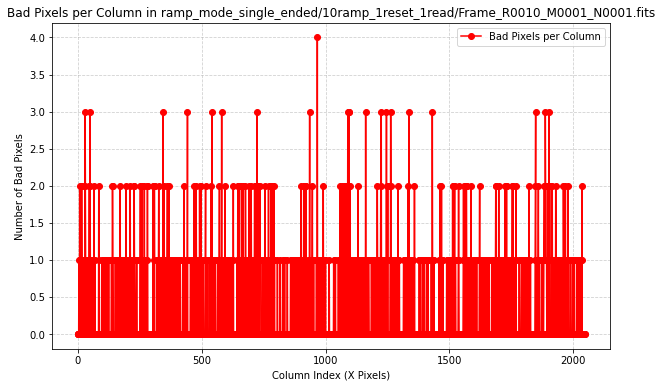

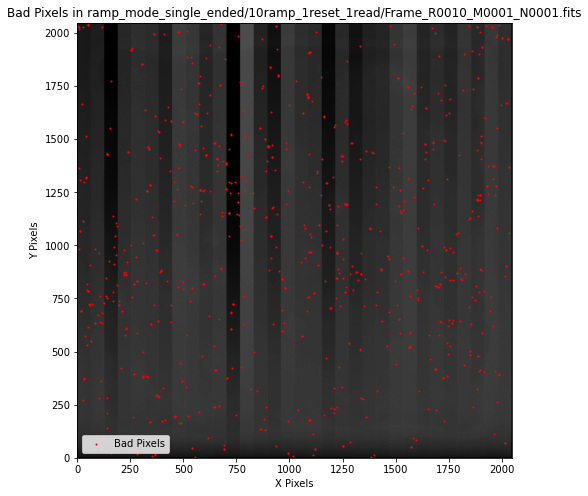

Column 0: 0 bad pixels
Column 1: 0 bad pixels
Column 2: 0 bad pixels
Column 3: 0 bad pixels
Column 4: 0 bad pixels
Column 5: 1 bad pixels
Column 6: 0 bad pixels
Column 7: 0 bad pixels
Column 8: 2 bad pixels
Column 9: 0 bad pixels
Column 10: 1 bad pixels
Column 11: 1 bad pixels
Column 12: 0 bad pixels
Column 13: 1 bad pixels
Column 14: 2 bad pixels
Column 15: 0 bad pixels
Column 16: 2 bad pixels
Column 17: 1 bad pixels
Column 18: 0 bad pixels
Column 19: 0 bad pixels
Column 20: 0 bad pixels
Column 21: 0 bad pixels
Column 22: 0 bad pixels
Column 23: 0 bad pixels
Column 24: 1 bad pixels
Column 25: 0 bad pixels
Column 26: 0 bad pixels
Column 27: 0 bad pixels
Column 28: 1 bad pixels
Column 29: 0 bad pixels
Column 30: 3 bad pixels
Column 31: 2 bad pixels
Column 32: 1 bad pixels
Column 33: 1 bad pixels
Column 34: 0 bad pixels
Column 35: 0 bad pixels
Column 36: 1 bad pixels
Column 37: 0 bad pixels
Column 38: 0 bad pixels
Column 39: 0 bad pixels
Column 40: 0 bad pixels
Column 41: 0 bad pixels
Co

In [48]:
# Function to count and locate bad pixels
def count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size):
    # Calculate local mean and standard deviation for each pixel
    local_mean = gaussian_filter(image_data, sigma=neighborhood_size)
    local_std = np.sqrt(gaussian_filter((image_data - local_mean)**2, sigma=neighborhood_size))

    # Define threshold based on local statistics
    threshold = local_mean + threshold_factor * local_std

    # Identify bad pixels based on thresholding
    bad_pixel_mask = image_data > threshold

    # Get coordinates of bad pixels
    bad_pixel_coords = np.argwhere(bad_pixel_mask)
    num_bad_pixels = len(bad_pixel_coords)

    return num_bad_pixels, bad_pixel_coords, bad_pixel_mask

# Function to process a FITS file and count bad pixels per column
def process_image(fits_filename, threshold_factor, neighborhood_size):
    # Read FITS file
    hdul = fits.open(fits_filename)
    image_data = hdul[0].data
    hdul.close()

    # Count and locate bad pixels
    num_bad_pixels, bad_pixel_coords, bad_pixel_mask = count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size)

    print(f"Number of bad pixels in {fits_filename}:", num_bad_pixels)
    print(f"Coordinates of bad pixels in {fits_filename}:", bad_pixel_coords)

    # Count bad pixels per column (sum mask along the Y-axis)
    bad_pixels_per_column = np.sum(bad_pixel_mask, axis=0)

    # Plot bad pixel distribution per column
    plt.figure(figsize=(10, 6))
    plt.plot(bad_pixels_per_column, marker='o', linestyle='-', color='r', label='Bad Pixels per Column')
    plt.title(f'Bad Pixels per Column in {fits_filename}')
    plt.xlabel('Column Index (X Pixels)')
    plt.ylabel('Number of Bad Pixels')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

    # Plot the original image with bad pixels marked
    plt.figure(figsize=(10, 8))
    plt.imshow(image_data, cmap='gray', origin='lower')
    plt.scatter(bad_pixel_coords[:, 1], bad_pixel_coords[:, 0], color='red', s=1, label='Bad Pixels')
    plt.title(f'Bad Pixels in {fits_filename}')
    plt.xlabel('X Pixels')
    plt.ylabel('Y Pixels')
    plt.legend()
    plt.show()

    return image_data, bad_pixels_per_column, bad_pixel_coords, bad_pixel_mask  

fits_filename = 'ramp_mode_single_ended/10ramp_1reset_1read/Frame_R0010_M0001_N0001.fits'
threshold_factor = 50.0  # Set a threshold factor (adjust as needed)
neighborhood_size = 5  # Set the Gaussian filter size (adjust as needed)

image_data ,bad_pixels_per_column, bad_pixel_coords, bad_pixel_mask = process_image(fits_filename, threshold_factor, neighborhood_size)


# Optionally, print the bad pixels count for each column
# for col_index, bad_pixel_count in enumerate(bad_pixels_per_column):
#     print(f'Column {col_index}: {bad_pixel_count} bad pixels')

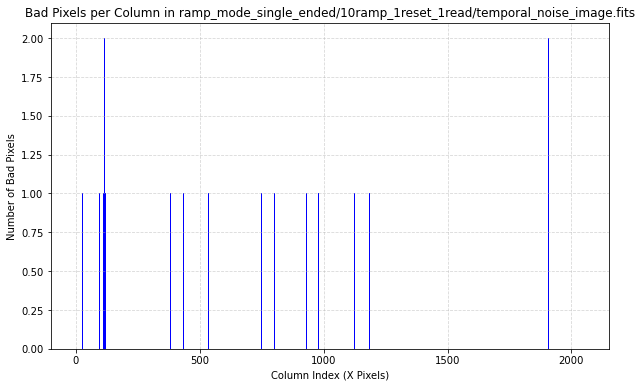

In [28]:
# Bar chart showing bad pixels per column
plt.figure(figsize=(10, 6))
plt.bar(range(len(bad_pixels_per_column)), bad_pixels_per_column, color='b')
plt.title(f'Bad Pixels per Column in {fits_filename}')
plt.xlabel('Column Index (X Pixels)')
plt.ylabel('Number of Bad Pixels')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


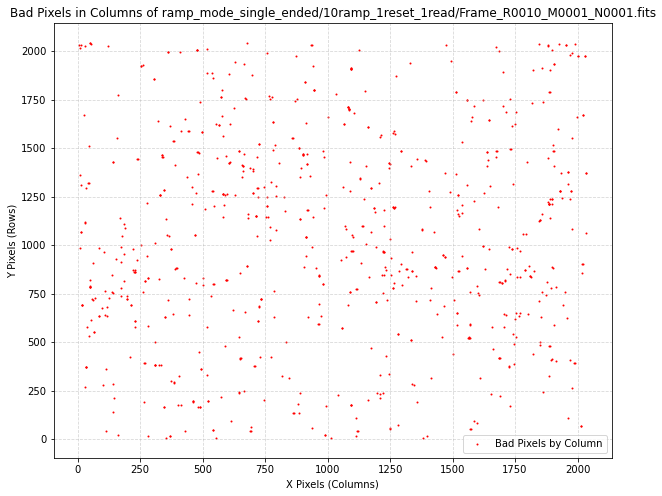

Columns with bad pixels: [   5    8   10   11   13   14   16   17   24   28   30   31   32   33
   36   42   43   44   45   47   49   50   51   52   58   59   62   66
   69   85   86   97  102  105  107  110  111  114  116  118  119  125
  136  137  140  141  142  143  152  157  159  160  167  171  172  174
  177  184  185  186  188  195  198  208  212  219  221  223  227  228
  229  230  237  238  239  252  253  260  264  266  267  269  276  278
  281  282  304  308  309  310  320  323  326  327  328  332  335  336
  338  339  344  345  349  352  353  357  361  362  364  368  369  372
  373  374  379  380  383  384  386  389  390  394  395  402  405  408
  413  414  424  429  438  442  443  455  456  459  461  462  469  471
  474  476  477  478  479  480  481  483  485  487  489  490  492  497
  499  500  507  515  516  518  521  522  531  538  539  540  542  543
  546  553  554  555  564  565  571  572  576  579  580  581  583  585
  588  591  594  595  597  599  605  606  607  608  

In [43]:
# Now focus on bad pixels from columns only:
columns_with_bad_pixels = np.unique(bad_pixel_coords[:, 1])  # Extract unique column indices with bad pixels

# Create a scatter plot that shows bad pixels in columns (X axis only)
plt.figure(figsize=(10, 8))

# Plot bad pixels by columns only (ignoring y-coordinates/rows)
plt.scatter(bad_pixel_coords[:, 1], bad_pixel_coords[:, 0], c='r', s=1, label='Bad Pixels by Column')
plt.title(f'Bad Pixels in Columns of {fits_filename}')
plt.xlabel('X Pixels (Columns)')
plt.ylabel('Y Pixels (Rows)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

# Print the columns that have bad pixels
print(f"Columns with bad pixels: {columns_with_bad_pixels}")


In [46]:
# Number of columns per channel
columns_per_channel = 64

# Calculate the number of channels
num_channels = len(bad_pixels_per_column) // columns_per_channel

# Sum bad pixels for each channel
bad_pixels_per_channel = [np.sum(bad_pixels_per_column[i * columns_per_channel:(i + 1) * columns_per_channel])
    for i in range(num_channels)]

# Find the channel with the minimum number of bad pixels
min_bad_pixels_channel = np.argmin(bad_pixels_per_channel)
min_bad_pixels_count = bad_pixels_per_channel[min_bad_pixels_channel]

print(f"Channel with the minimum number of bad pixels: {min_bad_pixels_channel}")
print(f"Number of bad pixels in this channel: {min_bad_pixels_count}")

Channel with the minimum number of bad pixels: 21
Number of bad pixels in this channel: 12


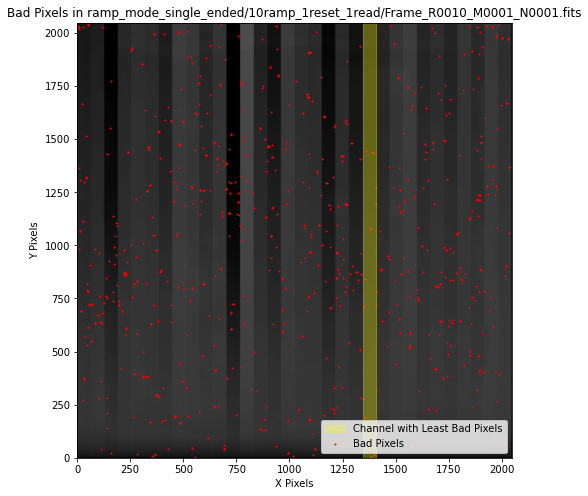

In [50]:
# Visualize the channel with the least number of bad pixels
start_col = min_bad_pixels_channel * columns_per_channel
end_col = start_col + columns_per_channel

# Plot the original image with the channel highlighted
plt.figure(figsize=(10, 8))
plt.imshow(image_data, cmap='gray', origin='lower')
plt.axvspan(start_col, end_col, color='yellow', alpha=0.3, label='Channel with Least Bad Pixels')
plt.scatter(bad_pixel_coords[:, 1], bad_pixel_coords[:, 0], color='red', s=1, label='Bad Pixels')
plt.title(f'Bad Pixels in {fits_filename}')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.legend()
plt.show()

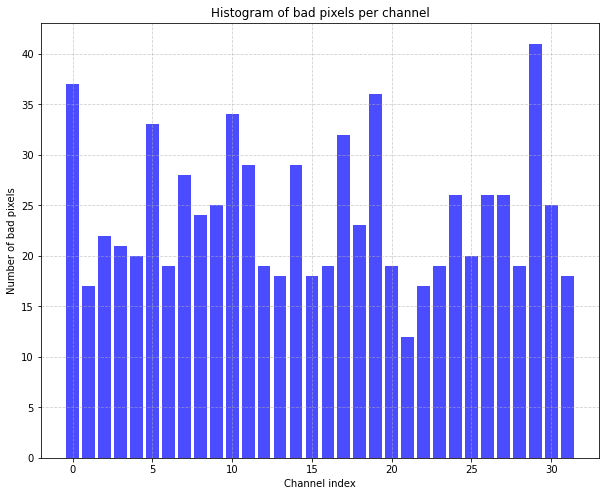

In [52]:
# histogram of bad pixels per channel
plt.figure(figsize=(10, 8))
plt.bar(range(num_channels), bad_pixels_per_channel, color='b', alpha=0.7)
plt.xlabel('Channel index')
plt.ylabel('Number of bad pixels')
plt.title('Histogram of bad pixels per channel')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Final analysis of the best region

In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter, generic_filter
from astropy.io import fits
import matplotlib.pyplot as plt

In [3]:
# Function to count and locate bad pixels
def count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size):
    local_mean = gaussian_filter(image_data, sigma=neighborhood_size)
    local_std = np.sqrt(gaussian_filter((image_data - local_mean)**2, sigma=neighborhood_size))
    threshold = local_mean + threshold_factor * local_std
    bad_pixel_mask = image_data > threshold
    bad_pixel_coords = np.argwhere(bad_pixel_mask)
    num_bad_pixels = len(bad_pixel_coords)
    return num_bad_pixels, bad_pixel_coords, bad_pixel_mask

# Calculate spatial noise using a window method
def calculate_spatial_noise_window(image_data, window_size):
    spatial_noise = generic_filter(image_data, np.std, size=window_size)
    return spatial_noise

# Calculate temporal noise
def calculate_temporal_noise(image_stack):
    temporal_noise = np.std(image_stack, axis=0)
    return temporal_noise

def process_image(fits_filename, threshold_factor, neighborhood_size, window_size):
    hdul = fits.open(fits_filename)
    image_data = hdul[0].data
    hdul.close()
    num_bad_pixels, bad_pixel_coords, bad_pixel_mask = count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size)
    spatial_noise = calculate_spatial_noise_window(image_data, window_size)
    return image_data, bad_pixel_mask, spatial_noise

# analyze channels
def process_images(fits_filenames, threshold_factor, neighborhood_size, window_size):
    image_stack = []
    for fits_filename in fits_filenames:
        image_data, bad_pixel_mask, spatial_noise = process_image(fits_filename, threshold_factor, neighborhood_size, window_size)
        image_stack.append(image_data)
    image_stack = np.array(image_stack)
    temporal_noise = calculate_temporal_noise(image_stack)
    channels = 32
    columns_per_channel = 64
    best_channel = None
    best_channel_score = float('inf')
    channel_scores = []
    for channel in range(channels):
        start_col = channel * columns_per_channel
        end_col = start_col + columns_per_channel
        channel_bad_pixels = np.sum(bad_pixel_mask[:, start_col:end_col])
        channel_spatial_noise = np.mean(spatial_noise[:, start_col:end_col])
        channel_temporal_noise = np.mean(temporal_noise[start_col:end_col])
        channel_score = channel_bad_pixels + channel_spatial_noise + channel_temporal_noise
        channel_scores.append(channel_score)
        if channel_score < best_channel_score:
            best_channel_score = channel_score
            best_channel = channel
    print(f"Best channel: {best_channel}")
    print(f"Score: {best_channel_score}")
    return best_channel, best_channel_score, channel_scores, image_stack

# best region within the best channel
def find_best_region(image_data, bad_pixel_mask, spatial_noise, region_height=36, region_width=156):
    rows, cols = image_data.shape
    min_bad_pixels = float('inf')
    min_spatial_noise = float('inf')
    best_region_start_row = 0
    best_region_start_col = 0
    
    for row in range(rows - region_height + 1):
        for col in range(cols - region_width + 1):
            region_bad_pixels = np.sum(bad_pixel_mask[row:row+region_height, col:col+region_width])
            region_spatial_noise = np.mean(spatial_noise[row:row+region_height, col:col+region_width])
            
            if (region_bad_pixels < min_bad_pixels) or (region_bad_pixels == min_bad_pixels and region_spatial_noise < min_spatial_noise):
                min_bad_pixels = region_bad_pixels
                min_spatial_noise = region_spatial_noise
                best_region_start_row = row
                best_region_start_col = col
    
    return best_region_start_row, best_region_start_col


*******************************
Best channel: 20
Score: 891.8737335060957

In [5]:
fits_filenames = [f'ramp_mode_single_ended/10ramp_1reset_1read/Frame_R{str(i).zfill(4)}_M0001_N0001.fits' for i in range(1, 11)]
threshold_factor = 50
neighborhood_size = 5
window_size = 10  
best_channel, best_channel_score, channel_scores, image_stack = process_images(fits_filenames, 
                                                                               threshold_factor, neighborhood_size, window_size)

Best channel: 16
Score: 377.5417355060334


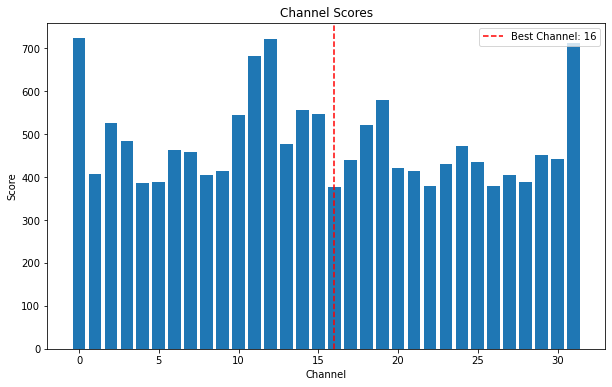

In [4]:
# Plot histogram of channel scores
plt.figure(figsize=(10, 6))
plt.bar(range(32), channel_scores)
plt.xlabel('Channel')
plt.ylabel('Score')
plt.title('Channel Scores')
plt.axvline(best_channel, color='r', linestyle='--', label=f'Best Channel: {best_channel}')
plt.legend()
plt.show()

In [6]:
# Extract the data for the best channel from the first frame of the image stack
best_channel= 16
start_col_best_channel = best_channel * 64
end_col_best_channel = start_col_best_channel + 64

best_channel_image_data = image_stack[1][:36, start_col_best_channel:end_col_best_channel]
best_channel_bad_pixel_mask = count_and_locate_bad_pixels(best_channel_image_data, threshold_factor, neighborhood_size)[2]
best_channel_spatial_noise = calculate_spatial_noise_window(best_channel_image_data, window_size)

In [5]:


# Find the best region within the best channel
best_region_start_row, best_region_start_col = find_best_region(best_channel_image_data,
                                                                best_channel_bad_pixel_mask,
                                                                best_channel_spatial_noise,
                                                                region_height=36,
                                                                region_width=156)

# Extract the area of interest (36x156 pixels) from the first frame of the best channel
area_of_interest = image_stack[0][best_region_start_row:best_region_start_row+36,
                                  start_col_best_channel+best_region_start_col:start_col_best_channel+best_region_start_col+156]


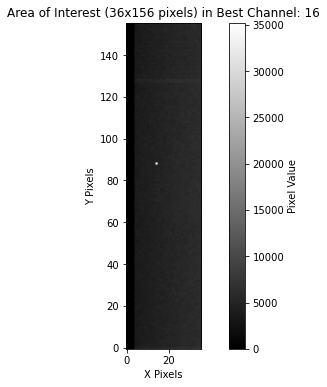

In [6]:
plt.figure(figsize=(10, 6))
plt.imshow(area_of_interest.T, cmap='gray', origin='lower')
plt.colorbar(label='Pixel Value')
plt.title(f'Area of Interest (36x156 pixels) in Best Channel: {best_channel}')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

In [5]:
def find_best_region_full_frame(image_data, bad_pixel_mask, spatial_noise, region_height=36, region_width=156):
    rows, cols = image_data.shape
    min_bad_pixels = float('inf')
    min_spatial_noise = float('inf')
    best_region_start_row = 0
    best_region_start_col = 0
    
    for row in range(rows - region_height + 1):
        for col in range(cols - region_width + 1):
            region_bad_pixels = np.sum(bad_pixel_mask[row:row+region_height, col:col+region_width])
            region_spatial_noise = np.mean(spatial_noise[row:row+region_height, col:col+region_width])
            
            if (region_bad_pixels < min_bad_pixels) or (region_bad_pixels == min_bad_pixels and region_spatial_noise < min_spatial_noise):
                min_bad_pixels = region_bad_pixels
                min_spatial_noise = region_spatial_noise
                best_region_start_row = row
                best_region_start_col = col
    
    return best_region_start_row, best_region_start_co

In [ ]:
full_frame_image_data = image_stack
full_frame_bad_pixel_mask = count_and_locate_bad_pixels(full_frame_image_data, threshold_factor, neighborhood_size)
full_frame_spatial_noise = calculate_spatial_noise_window(full_frame_image_data, window_size)

# Find the best region within the full frame image
best_region_start_row_full_frame, best_region_start_col_full_frame = find_best_region(full_frame_image_data,
                                                                                                full_frame_bad_pixel_mask,
                                                                                                full_frame_spatial_noise,
                                                                                                region_height=36,
                                                                                                region_width=156)

# Extract the area of interest (36x156 pixels) from the full frame image
area_of_interest_full_frame = full_frame_image_data[best_region_start_row_full_frame:best_region_start_row_full_frame+36,
                                                    best_region_start_col_full_frame:best_region_start_col_full_frame+156]

In [ ]:
print(f"Coordinates of the best region within the full frame image: Start Row: {best_region_start_row_full_frame}, Start Column: {best_region_start_col_full_frame}")

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(area_of_interest_full_frame, cmap='gray', origin='lower')
plt.colorbar(label='Pixel Value')
plt.title(f'Area of Interest (36x156 pixels) in Full Frame Image')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

In [ ]:
# # Function to count and locate bad pixels
# def count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size):
#     # Calculate local mean and standard deviation for each pixel
#     local_mean = gaussian_filter(image_data, sigma=neighborhood_size)
#     local_std = np.sqrt(gaussian_filter((image_data - local_mean)**2, sigma=neighborhood_size))

#     # Define threshold based on local statistics
#     threshold = local_mean + threshold_factor * local_std

#     # Identify bad pixels based on thresholding
#     bad_pixel_mask = image_data > threshold

#     # Get coordinates of bad pixels
#     bad_pixel_coords = np.argwhere(bad_pixel_mask)
#     num_bad_pixels = len(bad_pixel_coords)

#     return num_bad_pixels, bad_pixel_coords, bad_pixel_mask

# # Function to calculate spatial noise using a window method
# def calculate_spatial_noise_window(image_data, window_size):
#     spatial_noise = generic_filter(image_data, np.std, size=window_size)
#     return spatial_noise

# # Function to calculate temporal noise
# def calculate_temporal_noise(image_stack):
#     temporal_noise = np.std(image_stack, axis=0)
#     return temporal_noise

# # Function to process a single FITS file
# def process_image(fits_filename, threshold_factor, neighborhood_size, window_size):
#     # Read FITS file
#     hdul = fits.open(fits_filename)
#     image_data = hdul[0].data
#     hdul.close()

#     # Count and locate bad pixels
#     num_bad_pixels, bad_pixel_coords, bad_pixel_mask = count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size)

#     # Calculate spatial noise using window method
#     spatial_noise = calculate_spatial_noise_window(image_data, window_size)

#     return image_data, bad_pixel_mask, spatial_noise

# # Function to process multiple FITS files and analyze channels
# def process_images(fits_filenames, threshold_factor, neighborhood_size, window_size):
#     # Initialize an array to accumulate temporal noise data
#     image_stack = []

#     for fits_filename in fits_filenames:
#         # Process each FITS file
#         image_data, bad_pixel_mask, spatial_noise = process_image(fits_filename, threshold_factor, neighborhood_size, window_size)
#         image_stack.append(image_data)

#     # Convert the list to a numpy array for temporal noise calculation
#     image_stack = np.array(image_stack)

#     # Calculate temporal noise
#     temporal_noise = calculate_temporal_noise(image_stack)

#     # Analyze each channel
#     channels = 32
#     columns_per_channel = 64
#     best_channel = None
#     best_channel_score = float('inf')
    
#     channel_scores = []

#     for channel in range(channels):
#         start_col = channel * columns_per_channel
#         end_col = start_col + columns_per_channel

#         channel_bad_pixels = np.sum(bad_pixel_mask[:, start_col:end_col])
#         channel_spatial_noise = np.mean(spatial_noise[:, start_col:end_col])
#         channel_temporal_noise = np.mean(temporal_noise[start_col:end_col])

#         # Combine metrics to score the channel
#         channel_score = channel_bad_pixels + channel_spatial_noise + channel_temporal_noise
        
#         channel_scores.append(channel_score)

#         if channel_score < best_channel_score:
#             best_channel_score = channel_score
#             best_channel = channel

#     print(f"Best channel: {best_channel}")
#     print(f"Score: {best_channel_score}")

#     return best_channel, best_channel_score, channel_scores,image_stack


# fits_filenames = [f'ramp_mode_single_ended/10ramp_1reset_1read/Frame_R{str(i).zfill(4)}_M0001_N0001.fits' for i in range(1, 11)]
# threshold_factor = 50
# neighborhood_size = 5
# window_size = 10  

# best_channel, best_channel_score, channel_scores, image_stack = process_images(fits_filenames, threshold_factor, neighborhood_size, window_size)



# # Plot histogram of channel scores
# plt.figure(figsize=(12, 8))
# plt.bar(range(32), channel_scores)
# plt.xlabel('Channel')
# plt.ylabel('Score')
# plt.title('Channel Scores')
# plt.axvline(best_channel, color='r', linestyle='--', label=f'Best Channel: {best_channel}')
# plt.legend()
# plt.show()


# # Plot the area of 36x156 pixels in the best channel
# start_col_best_channel = best_channel * 64

# # Extract the area of interest (36x156 pixels) from the first frame of the best channel
# area_of_interest = image_stack[0][:36, start_col_best_channel:start_col_best_channel+156]

# plt.figure(figsize=(10, 6))
# plt.imshow(area_of_interest.T, cmap='gray', origin='lower')
# plt.colorbar(label='Pixel Value')
# plt.title(f'Area of Interest (36x156 pixels) in Best Channel: {best_channel}')
# plt.xlabel('X Pixels')
# plt.ylabel('Y Pixels')
# plt.show()

In [2]:
import numpy as np
from scipy.ndimage import gaussian_filter, generic_filter
from astropy.io import fits
import matplotlib.pyplot as plt


# Analyze channels
# def process_images(fits_filenames, threshold_factor, neighborhood_size, window_size):
#     image_stack = []
#     for fits_filename in fits_filenames:
#         image_data, bad_pixel_mask, spatial_noise = process_image(fits_filename, threshold_factor, neighborhood_size, window_size)
#         image_stack.append(image_data)
#     image_stack = np.array(image_stack)
#     temporal_noise = calculate_temporal_noise(image_stack)
#     channels = 32
#     columns_per_channel = 64
#     best_channel = None
#     best_channel_score = float('inf')
#     channel_scores = []
#     for channel in range(channels):
#         start_col = channel * columns_per_channel
#         end_col = start_col + columns_per_channel
#         channel_bad_pixels = np.sum(bad_pixel_mask[:, start_col:end_col])
#         channel_spatial_noise = np.mean(spatial_noise[:, start_col:end_col])
#         channel_temporal_noise = np.mean(temporal_noise[start_col:end_col])
#         channel_score = channel_bad_pixels + channel_spatial_noise + channel_temporal_noise
#         channel_scores.append(channel_score)
#         if channel_score < best_channel_score:
#             best_channel_score = channel_score
#             best_channel = channel
#     print(f"Best channel: {best_channel}")
#     print(f"Score: {best_channel_score}")
#     return best_channel, best_channel_score, channel_scores, image_stack

In [3]:
# Function to count and locate bad pixels
def count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size):
    local_mean = gaussian_filter(image_data, sigma=neighborhood_size)
    local_std = np.sqrt(gaussian_filter((image_data - local_mean)**2, sigma=neighborhood_size))
    threshold = local_mean + threshold_factor * local_std
    bad_pixel_mask = image_data > threshold
    bad_pixel_coords = np.argwhere(bad_pixel_mask)
    num_bad_pixels = len(bad_pixel_coords)
    return num_bad_pixels, bad_pixel_coords, bad_pixel_mask

# Calculate spatial noise using a window method
def calculate_spatial_noise_window(image_data, window_size):
    spatial_noise = generic_filter(image_data, np.std, size=window_size)
    return spatial_noise

# Calculate temporal noise
def calculate_temporal_noise(image_stack):
    temporal_noise = np.std(image_stack, axis=0)
    return temporal_noise

def process_image(fits_filename, threshold_factor, neighborhood_size, window_size):
    hdul = fits.open(fits_filename)
    image_data = hdul[0].data
    hdul.close()
    num_bad_pixels, bad_pixel_coords, bad_pixel_mask = count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size)
    spatial_noise = calculate_spatial_noise_window(image_data, window_size)
    return image_data, bad_pixel_mask, spatial_noise


def process_images(fits_filenames, threshold_factor, neighborhood_size, window_size):
    image_stack = []
    spatial_noise_stack = []  # To store spatial noise of each image
    bad_pixel_mask_stack = []
    
    for fits_filename in fits_filenames:
        image_data, bad_pixel_mask, spatial_noise = process_image(fits_filename, threshold_factor, neighborhood_size, window_size)
        image_stack.append(image_data)
        spatial_noise_stack.append(spatial_noise)
        bad_pixel_mask_stack.append(bad_pixel_mask)

    # Combine into numpy arrays for further processing
    image_stack = np.array(image_stack)
    spatial_noise_stack = np.array(spatial_noise_stack)
    bad_pixel_mask_stack = np.array(bad_pixel_mask_stack)
    
    # Calculate temporal noise
    temporal_noise = calculate_temporal_noise(image_stack)
    
    # Analyze channels (you already have this part)
    channels = 32
    columns_per_channel = 64
    best_channel = None
    best_channel_score = float('inf')
    channel_scores = []
    
    for channel in range(channels):
        start_col = channel * columns_per_channel
        end_col = start_col + columns_per_channel
        
        # Combine bad pixel masks across all frames for the current channel
        combined_bad_pixel_mask = np.any(bad_pixel_mask_stack[:, :, start_col:end_col], axis=0)
        
        channel_bad_pixels = np.sum(combined_bad_pixel_mask)
        channel_spatial_noise = np.mean(spatial_noise_stack[:, :, start_col:end_col])
        channel_temporal_noise = np.mean(temporal_noise[start_col:end_col])
        
        # Calculate channel score
        channel_score = channel_bad_pixels + channel_spatial_noise + channel_temporal_noise
        channel_scores.append(channel_score)
        
        if channel_score < best_channel_score:
            best_channel_score = channel_score
            best_channel = channel

    print(f"Best channel: {best_channel}")
    print(f"Score: {best_channel_score}")
    
    return best_channel, best_channel_score, channel_scores, image_stack, spatial_noise_stack, temporal_noise, bad_pixel_mask_stack



# Best region within the best channel
def find_best_region_in_channel(image_data, bad_pixel_mask, spatial_noise, temporal_noise, best_channel, region_height=36, region_width=159):
    rows, cols = image_data.shape[:2]
    columns_per_channel = 64  # Fixed number of columns per channel
    start_col = best_channel * columns_per_channel
    end_col = start_col + columns_per_channel

    # Adjust width if it exceeds the channel width (64)
    if region_width > columns_per_channel:
        print(f"Warning: Region width {region_width} exceeds channel width {columns_per_channel}. Adjusting to {columns_per_channel}.")
        region_width = columns_per_channel

    min_bad_pixels = float('inf')
    min_combined_noise = float('inf')
    best_region_start_row = 0
    best_region_start_col = 0
    
    # Search within the best channel columns
    for row in range(rows - region_height + 1):
        for col in range(start_col, end_col - region_width + 1):  # Limit search within the channel's 64 columns
            region_bad_pixels = np.sum(bad_pixel_mask[row:row+region_height, col:col+region_width])
            region_spatial_noise = np.mean(spatial_noise[row:row+region_height, col:col+region_width])
            region_temporal_noise = np.mean(temporal_noise[row:row+region_height, col:col+region_width])
            combined_noise = region_spatial_noise + region_temporal_noise
            
            if (region_bad_pixels < min_bad_pixels) or (region_bad_pixels == min_bad_pixels and combined_noise < min_combined_noise):
                min_bad_pixels = region_bad_pixels
                min_combined_noise = combined_noise
                best_region_start_row = row
                best_region_start_col = col
    
    return best_region_start_row, best_region_start_col


def visualize_best_region_on_full_frame(image_data, best_region_start_row, best_region_start_col, region_height, region_width):
    plt.figure(figsize=(10, 8))
    plt.imshow(image_data, cmap='gray', origin='lower')

    # Draw a rectangle showing the best region
    rect = plt.Rectangle((best_region_start_col, best_region_start_row), region_width, region_height, 
                         edgecolor='red', facecolor='none', linewidth=2, label='Best Region')
    plt.gca().add_patch(rect)
    
    plt.title('Best Region on Full Detector Frame')
    plt.xlabel('X Pixels (Columns)')
    plt.ylabel('Y Pixels (Rows)')
#     plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

In [4]:
fits_filenames = [f'ramp_mode_single_ended/10ramp_1reset_1read/Frame_R{str(i).zfill(4)}_M0001_N0001.fits' for i in range(1, 11)]
threshold_factor = 50
neighborhood_size = 5
window_size = 10  
# best_channel, best_channel_score, channel_scores, image_stack = process_images(fits_filenames, 
#                                                                                threshold_factor, 
#                                                                                neighborhood_size, window_size)

best_channel, best_channel_score, channel_scores, image_stack, spatial_noise_stack, temporal_noise, bad_pixel_mask_stack = process_images(fits_filenames, 
                                                                                                                                          threshold_factor, neighborhood_size, 
                                                                                                                                          window_size)



Best channel: 16
Score: 377.34549069402163


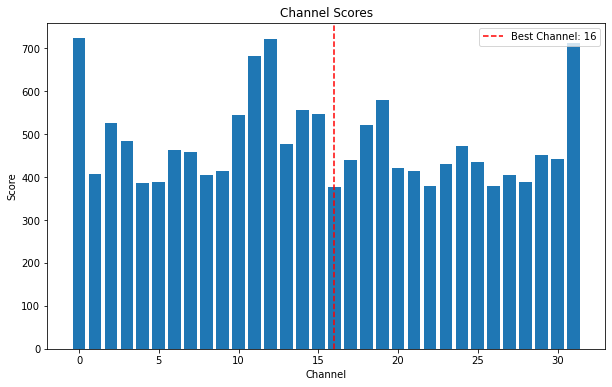

In [11]:
# Plot histogram of channel scores
plt.figure(figsize=(10, 6))
plt.bar(range(32), channel_scores)
plt.xlabel('Channel')
plt.ylabel('Score')
plt.title('Channel Scores')
plt.axvline(best_channel, color='r', linestyle='--', label=f'Best Channel: {best_channel}')
plt.legend()
plt.show()

In [7]:
def find_best_region(image_data, bad_pixel_mask, spatial_noise, temporal_noise, region_height=159, region_width=36):
    rows, cols = image_data.shape[:2]
    min_bad_pixels = float('inf')
    min_combined_noise = float('inf')
    best_region_start_row = 0
    best_region_start_col = 0
    
    # Loop through columns and rows ensuring the window is tall (159 rows) and narrow (36 columns)
    for col in range(cols - region_width + 1):  # Move across columns
        for row in range(rows - region_height + 1):  # Move down rows
            # Extract the region
            region_bad_pixels = np.sum(bad_pixel_mask[row:row + region_height, col:col + region_width])
            region_spatial_noise = np.mean(spatial_noise[row:row + region_height, col:col + region_width])
            region_temporal_noise = np.mean(temporal_noise[row:row + region_height, col:col + region_width])
            
            # Combine spatial and temporal noise
            combined_noise = region_spatial_noise + region_temporal_noise
            
            # Choose the region with the fewest bad pixels or the lowest noise if bad pixels are the same
            if (region_bad_pixels < min_bad_pixels) or (region_bad_pixels == min_bad_pixels and combined_noise < min_combined_noise):
                min_bad_pixels = region_bad_pixels
                min_combined_noise = combined_noise
                best_region_start_row = row
                best_region_start_col = col

    return best_region_start_row, best_region_start_col

In [10]:
# Initialize combined bad pixel mask
combined_bad_pixel_mask = np.zeros_like(image_stack[0], dtype=bool)

# Loop over the image stack to combine bad pixel masks
for image in image_stack:
    _, bad_pixel_coords, bad_pixel_mask = count_and_locate_bad_pixels(image, threshold_factor, neighborhood_size)
    combined_bad_pixel_mask |= bad_pixel_mask  # Combine masks (logical OR)

# Now combined_bad_pixel_mask should be defined


In [11]:
_, bad_pixel_coords, bad_pixel_mask = count_and_locate_bad_pixels(image_stack[0], threshold_factor, neighborhood_size)

# Now pass bad_pixel_mask to the find_best_region function
best_region_start_row, best_region_start_col = find_best_region(
    image_stack[0], 
    bad_pixel_mask,  # Use bad_pixel_mask for the first image
    spatial_noise_stack[0], 
    temporal_noise, 
    region_height=region_height, 
    region_width=region_width
)


In [12]:
# Define region dimensions for the best region (tall and narrow)
region_height = 159  # Number of rows (vertical height)
region_width = 36    # Number of columns (horizontal width)


Error: Best region column (709) is not in the best channel (16) range!
Best region coordinates: Start Row = 1529, Start Column = 709
Region Dimensions: Width = 36, Height = 159
Channel 16 column range: 1024 to 1088


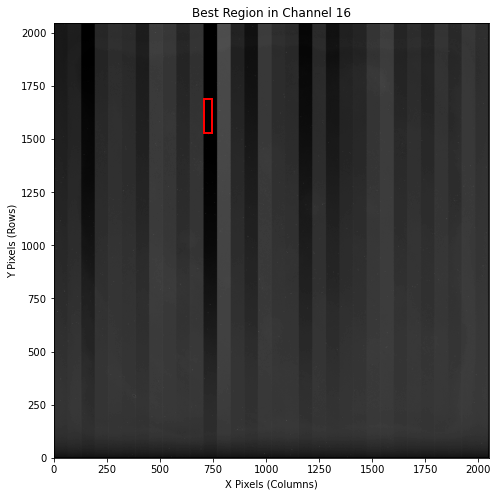

In [13]:
# Ensure you're looking at Channel 16
channel_start_col = best_channel * 64  # Start of Channel 16
channel_end_col = channel_start_col + 64  # End of Channel 16

# Now, make sure to search for the best region only within the columns of the best channel
# Check if the best_region_start_col lies within the channel bounds
if not (channel_start_col <= best_region_start_col < channel_end_col):
    print(f"Error: Best region column ({best_region_start_col}) is not in the best channel ({best_channel}) range!")
    
    


# Visualize the best region within the frame
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image_stack[0], cmap='gray')  # No need to flip the image

# Draw the best region as a rectangle (ensure it's within Channel 16)
rect = plt.Rectangle(
    (best_region_start_col, best_region_start_row), 
    region_width, region_height,  # Keep width and height as is
    edgecolor='red', facecolor='none', linewidth=2
)
ax.add_patch(rect)

# Display the coordinates of the rectangle
print(f"Best region coordinates: Start Row = {best_region_start_row}, Start Column = {best_region_start_col}")
print(f"Region Dimensions: Width = {region_width}, Height = {region_height}")
print(f"Channel {best_channel} column range: {channel_start_col} to {channel_end_col}")

plt.title(f'Best Region in Channel {best_channel}')
plt.xlabel('X Pixels (Columns)')
plt.ylabel('Y Pixels (Rows)')

# Invert the Y-axis to start from 0 at the bottom
ax.invert_yaxis()

plt.show()


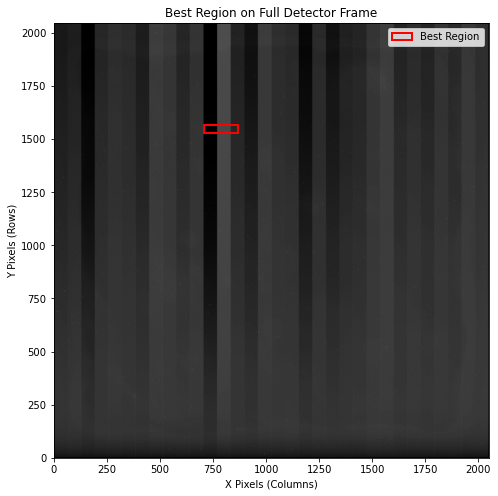

In [38]:
# Find the best region in the best channel
spatial_noise = spatial_noise_stack[1]  # Use the spatial noise of the first image
combined_bad_pixel_mask = np.any(bad_pixel_mask_stack, axis=0)  # Combine bad pixel masks across all frames

best_region_start_row, best_region_start_col = find_best_region(image_stack[0], combined_bad_pixel_mask,spatial_noise_stack[0],
                                                                temporal_noise, region_height=159, region_width=36)


# Visualize the best region on the full frame
visualize_best_region_on_full_frame(image_stack[0], best_region_start_row, best_region_start_col, 36, 159)


In [5]:
def find_best_region(image_data, bad_pixel_mask, spatial_noise, temporal_noise, region_height=159, region_width=36):
    rows, cols = image_data.shape[:2]
    min_bad_pixels = float('inf')
    min_combined_noise = float('inf')
    best_region_start_row = 0
    best_region_start_col = 0
    
    # Loop through columns and rows ensuring the window is tall (159 rows) and narrow (36 columns)
    for col in range(cols - region_width + 1):  # Move across columns
        for row in range(rows - region_height + 1):  # Move down rows
            # Extract the region
            region_bad_pixels = np.sum(bad_pixel_mask[row:row + region_height, col:col + region_width])
            region_spatial_noise = np.mean(spatial_noise[row:row + region_height, col:col + region_width])
            region_temporal_noise = np.mean(temporal_noise[row:row + region_height, col:col + region_width])
            
            # Combine spatial and temporal noise
            combined_noise = region_spatial_noise + region_temporal_noise
            
            # Choose the region with the fewest bad pixels or the lowest noise if bad pixels are the same
            if (region_bad_pixels < min_bad_pixels) or (region_bad_pixels == min_bad_pixels and combined_noise < min_combined_noise):
                min_bad_pixels = region_bad_pixels
                min_combined_noise = combined_noise
                best_region_start_row = row
                best_region_start_col = col

    return best_region_start_row, best_region_start_col

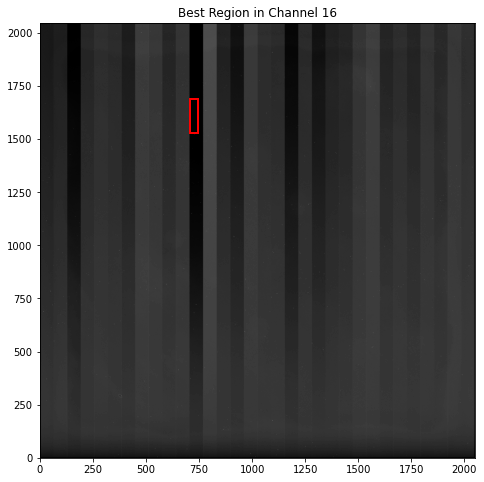

In [52]:
# Define region dimensions for the best region (tall and narrow)
region_height = 159  # Number of rows (vertical height)
region_width = 36    # Number of columns (horizontal width)

# Call the function to find the best vertical region
best_region_start_row, best_region_start_col = find_best_region(
    image_stack[0], 
    combined_bad_pixel_mask, 
    spatial_noise_stack[0], 
    temporal_noise, 
    region_height=region_height,  # Set height (tall)
    region_width=region_width     # Set width (narrow)
)


# Visualize the region
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image_stack[0], cmap='gray')
rect = plt.Rectangle(
    (best_region_start_col, best_region_start_row), 
    region_width, region_height, 
    edgecolor='red', facecolor='none', linewidth=2
)
ax.add_patch(rect)
plt.title(f'Best Region in Channel {best_channel}')
ax.invert_yaxis()
plt.show()

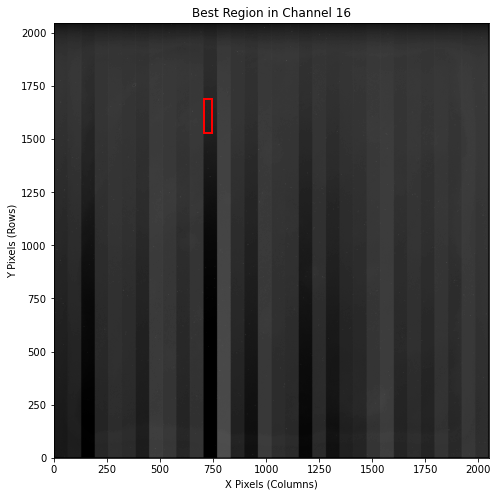

In [50]:
# Visualize the best region within the frame
fig, ax = plt.subplots(figsize=(10, 8))
# Flip the image vertically
flipped_image = np.flipud(image_stack[0])  # Flip the image upside down
ax.imshow(flipped_image, cmap='gray')

# Draw the best region as a rectangle (the rectangle will still be defined as before)
rect = plt.Rectangle(
    (best_region_start_col, best_region_start_row), 
    region_width, region_height,  # Keep width and height as is
    edgecolor='red', facecolor='none', linewidth=2
)
ax.add_patch(rect)

plt.title(f'Best Region in Channel {best_channel}')
plt.xlabel('X Pixels (Columns)')
plt.ylabel('Y Pixels (Rows)')

plt.show()

In [48]:
print(f"Best region coordinates: Start Row = {best_region_start_row}, Start Column = {best_region_start_col}")
print(f"Region Dimensions: Width = {region_width}, Height = {region_height}")

Best region coordinates: Start Row = 1529, Start Column = 709
Region Dimensions: Width = 36, Height = 159


In [20]:
# Extract the data for the best channel from the first frame of the image stack
start_col_best_channel = best_channel * 64
end_col_best_channel = start_col_best_channel + 64

best_channel_image_data = image_stack[:, start_col_best_channel:end_col_best_channel]
best_channel_bad_pixel_mask = count_and_locate_bad_pixels(best_channel_image_data, threshold_factor, neighborhood_size)
best_channel_spatial_noise = calculate_spatial_noise_window(best_channel_image_data, window_size)
best_channel_temporal_noise = calculate_temporal_noise(image_stack[:, :, start_col_best_channel:end_col_best_channel])

# Find the best region within the best channel
best_region_start_row, best_region_start_col = find_best_region(best_channel_image_data,
                                                                best_channel_bad_pixel_mask,
                                                                best_channel_spatial_noise,
                                                                best_channel_temporal_noise,
                                                                region_height=36,
                                                                region_width=159)

# Extract the area of interest (36x159 pixels) from the first frame of the best channel
area_of_interest = image_stack[best_region_start_row:best_region_start_row+36,
                                  start_col_best_channel+best_region_start_col:start_col_best_channel+best_region_start_col+159]


In [21]:
# Print the coordinates of the best region within the full frame image
print(f"Coordinates of the best region within the full frame image: Start Row: {best_region_start_row}, Start Column: {start_col_best_channel + best_region_start_col}")

Coordinates of the best region within the full frame image: Start Row: 0, Start Column: 1024


TypeError: Invalid shape (10, 159, 2048) for image data

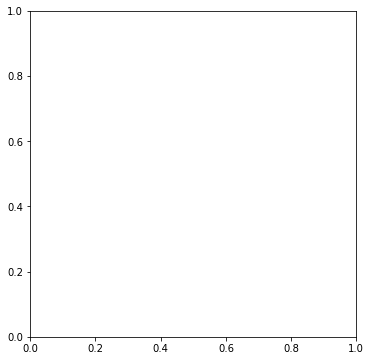

In [23]:
area_of_interest_2d = area_of_interest
plt.figure(figsize=(10, 6))
plt.imshow(area_of_interest, cmap='gray', origin='lower')
plt.colorbar(label='Pixel Value')
plt.title(f'Area of Interest (36x159 pixels) in Best Channel: {best_channel}')
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')
plt.show()

In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter, generic_filter
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
# Function to count and locate bad pixels
def count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size):
    local_mean = gaussian_filter(image_data, sigma=neighborhood_size)
    local_std = np.sqrt(gaussian_filter((image_data - local_mean)**2, sigma=neighborhood_size))
    threshold = local_mean + threshold_factor * local_std
    bad_pixel_mask = image_data > threshold
    bad_pixel_coords = np.argwhere(bad_pixel_mask)
    num_bad_pixels = len(bad_pixel_coords)
    return num_bad_pixels, bad_pixel_coords, bad_pixel_mask

# Calculate spatial noise using a window method
def calculate_spatial_noise_window(image_data, window_size):
    spatial_noise = generic_filter(image_data, np.std, size=window_size)
    return spatial_noise

# Calculate temporal noise
def calculate_temporal_noise(image_stack):
    temporal_noise = np.std(image_stack, axis=0)
    return temporal_noise

def process_image(fits_filename, threshold_factor, neighborhood_size, window_size):
    hdul = fits.open(fits_filename)
    image_data = hdul[0].data
    hdul.close()
    num_bad_pixels, bad_pixel_coords, bad_pixel_mask = count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size)
    spatial_noise = calculate_spatial_noise_window(image_data, window_size)
    return image_data, bad_pixel_mask, spatial_noise

def process_images(fits_filenames, threshold_factor, neighborhood_size, window_size):
    image_stack = []
    spatial_noise_stack = []  # To store spatial noise of each image
    bad_pixel_mask_stack = []
    
    for fits_filename in fits_filenames:
        image_data, bad_pixel_mask, spatial_noise = process_image(fits_filename, threshold_factor, neighborhood_size, window_size)
        image_stack.append(image_data)
        spatial_noise_stack.append(spatial_noise)
        bad_pixel_mask_stack.append(bad_pixel_mask)

    # Combine into numpy arrays for further processing
    image_stack = np.array(image_stack)
    spatial_noise_stack = np.array(spatial_noise_stack)
    bad_pixel_mask_stack = np.array(bad_pixel_mask_stack)
    
    # Calculate temporal noise
    temporal_noise = calculate_temporal_noise(image_stack)
    
    # Analyze channels
    channels = 32
    columns_per_channel = 64
    best_channel = None
    best_channel_score = float('inf')
    channel_scores = []
    
    for channel in range(channels):
        start_col = channel * columns_per_channel
        end_col = start_col + columns_per_channel
        
        # Combine bad pixel masks across all frames for the current channel
        combined_bad_pixel_mask = np.any(bad_pixel_mask_stack[:, :, start_col:end_col], axis=0)
        
        channel_bad_pixels = np.sum(combined_bad_pixel_mask)
        channel_spatial_noise = np.mean(spatial_noise_stack[:, :, start_col:end_col])
        channel_temporal_noise = np.mean(temporal_noise[start_col:end_col])
        
        # Calculate channel score
        channel_score = channel_bad_pixels + channel_spatial_noise + channel_temporal_noise
        channel_scores.append(channel_score)
        
        if channel_score < best_channel_score:
            best_channel_score = channel_score
            best_channel = channel

    print(f"Best channel: {best_channel}")
    print(f"Score: {best_channel_score}")
    
    return best_channel, best_channel_score, channel_scores, image_stack, spatial_noise_stack, temporal_noise, bad_pixel_mask_stack

# Best region within the best channel
def find_best_region_in_channel(image_data, bad_pixel_mask, spatial_noise, temporal_noise, best_channel, region_height=159, region_width=36):
    rows, cols = image_data.shape[:2]
    columns_per_channel = 64  # Fixed number of columns per channel
    start_col = best_channel * columns_per_channel
    end_col = start_col + columns_per_channel

    # Adjust width if it exceeds the channel width (64)
    if region_width > columns_per_channel:
        print(f"Warning: Region width {region_width} exceeds channel width {columns_per_channel}. Adjusting to {columns_per_channel}.")
        region_width = columns_per_channel

    min_bad_pixels = float('inf')
    min_combined_noise = float('inf')
    best_region_start_row = 0
    best_region_start_col = 0
    
    # Search within the best channel columns
    for row in range(rows - region_height + 1):
        for col in range(start_col, end_col - region_width + 1):  # Limit search within the channel's 64 columns
            region_bad_pixels = np.sum(bad_pixel_mask[row:row+region_height, col:col+region_width])
            region_spatial_noise = np.mean(spatial_noise[row:row+region_height, col:col+region_width])
            region_temporal_noise = np.mean(temporal_noise[row:row+region_height, col:col+region_width])
            combined_noise = region_spatial_noise + region_temporal_noise
            
            if (region_bad_pixels < min_bad_pixels) or (region_bad_pixels == min_bad_pixels and combined_noise < min_combined_noise):
                min_bad_pixels = region_bad_pixels
                min_combined_noise = combined_noise
                best_region_start_row = row
                best_region_start_col = col
    
    return best_region_start_row, best_region_start_col

def visualize_best_region_on_full_frame(image_data, best_region_start_row, best_region_start_col, region_height=159, region_width=36):
    plt.figure(figsize=(10, 8))
    plt.imshow(image_data, cmap='gray', origin='lower')

    # Draw a rectangle showing the best region
    rect = plt.Rectangle((best_region_start_col, best_region_start_row), region_width, region_height,
                         edgecolor='red', facecolor='none', linewidth=2, label='Best Region')
    plt.gca().add_patch(rect)
    
    plt.title('Best Region on Full Detector Frame')
    plt.xlabel('X Pixels')
    plt.ylabel('Y Pixels')
    plt.legend()
    plt.show()

# Plot histogram of channel scores
def plot_channel_scores(channel_scores, best_channel):
    plt.figure(figsize=(10, 6))
    plt.bar(range(32), channel_scores)
    plt.xlabel('Channel')
    plt.ylabel('Score')
    plt.title('Channel Scores')
    plt.axvline(best_channel, color='r', linestyle='--', label=f'Best Channel: {best_channel}')
    plt.legend()
    plt.show()



In [3]:
fits_filenames = [f'ramp_mode_single_ended/10ramp_1reset_1read/Frame_R{str(i).zfill(4)}_M0001_N0001.fits' for i in range(1, 11)]
threshold_factor = 50
neighborhood_size = 5
window_size = 10  

best_channel, best_channel_score, channel_scores, image_stack, spatial_noise_stack, temporal_noise, bad_pixel_mask_stack = process_images(
    fits_filenames, threshold_factor, neighborhood_size, window_size)

Best channel: 16
Score: 377.34549069402163


In [4]:
# Find the best region within the best channel
best_region_start_row, best_region_start_col = find_best_region_in_channel(
    image_stack[0], 
    bad_pixel_mask_stack[0],  # Use bad_pixel_mask for the first image
    spatial_noise_stack[0], 
    temporal_noise, 
    best_channel,  # Pass the best channel
    region_height=159, 
    region_width=36
)

In [5]:
# Ensure you're looking at the best channel
channel_start_col = best_channel * 64  # Start of the best channel
channel_end_col = channel_start_col + 64  # End of the best channel

# Check if the best_region_start_col lies within the channel bounds
if not (channel_start_col <= best_region_start_col < channel_end_col):
    print(f"Error: Best region column ({best_region_start_col}) is not in the best channel ({best_channel}) range!")

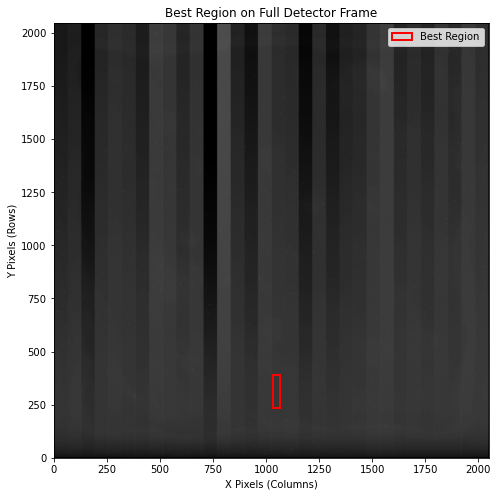

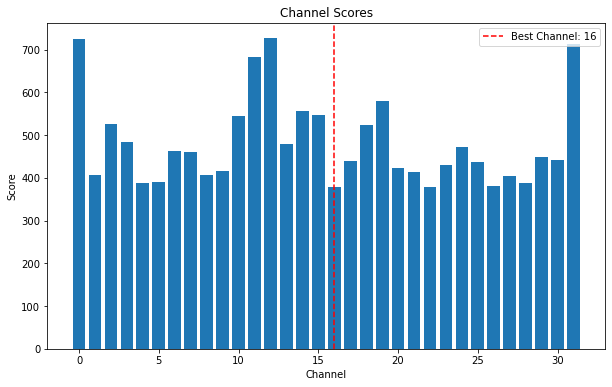

In [6]:
# Visualize the best region within the frame
visualize_best_region_on_full_frame(image_stack[0], best_region_start_row, best_region_start_col, region_height=159, region_width=36)

# Plot channel scores
plot_channel_scores(channel_scores, best_channel)

In [7]:
print(f"Best region coordinates: Start Row = {best_region_start_row}, Start Column = {best_region_start_col}")


Best region coordinates: Start Row = 232, Start Column = 1031


## fast mode 

In [3]:
import numpy as np
from scipy.ndimage import gaussian_filter, generic_filter
from astropy.io import fits
import matplotlib.pyplot as plt

# Function to count and locate bad pixels
def count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size):
    local_mean = gaussian_filter(image_data, sigma=neighborhood_size)
    local_std = np.sqrt(gaussian_filter((image_data - local_mean)**2, sigma=neighborhood_size))
    threshold = local_mean + threshold_factor * local_std
    bad_pixel_mask = image_data > threshold
    bad_pixel_coords = np.argwhere(bad_pixel_mask)
    num_bad_pixels = len(bad_pixel_coords)
    return num_bad_pixels, bad_pixel_coords, bad_pixel_mask

# Calculate spatial noise using a window method
def calculate_spatial_noise_window(image_data, window_size):
    spatial_noise = generic_filter(image_data, np.std, size=window_size)
    return spatial_noise

# Calculate temporal noise
def calculate_temporal_noise(image_stack):
    temporal_noise = np.std(image_stack, axis=0)
    return temporal_noise

def process_image(fits_filename, threshold_factor, neighborhood_size, window_size):
    hdul = fits.open(fits_filename)
    image_data = hdul[0].data
    hdul.close()
    num_bad_pixels, bad_pixel_coords, bad_pixel_mask = count_and_locate_bad_pixels(image_data, threshold_factor, neighborhood_size)
    spatial_noise = calculate_spatial_noise_window(image_data, window_size)
    return image_data, bad_pixel_mask, spatial_noise

def process_images(fits_filenames, threshold_factor, neighborhood_size, window_size):
    image_stack = []
    spatial_noise_stack = []  # To store spatial noise of each image
    bad_pixel_mask_stack = []
    
    for fits_filename in fits_filenames:
        image_data, bad_pixel_mask, spatial_noise = process_image(fits_filename, threshold_factor, neighborhood_size, window_size)
        image_stack.append(image_data)
        spatial_noise_stack.append(spatial_noise)
        bad_pixel_mask_stack.append(bad_pixel_mask)

    # Combine into numpy arrays for further processing
    image_stack = np.array(image_stack)
    spatial_noise_stack = np.array(spatial_noise_stack)
    bad_pixel_mask_stack = np.array(bad_pixel_mask_stack)
    
    # Calculate temporal noise
    temporal_noise = calculate_temporal_noise(image_stack)
    
    return image_stack, spatial_noise_stack, temporal_noise, bad_pixel_mask_stack

# Best region within the full frame for fast scan mode (window across columns)
def find_best_region_in_frame_fast_scan(image_data, bad_pixel_mask, spatial_noise, temporal_noise, region_height=36, region_width=159):
    rows, cols = image_data.shape[:2]

    min_bad_pixels = float('inf')
    min_combined_noise = float('inf')
    best_region_start_row = 0
    best_region_start_col = 0
    
    # Search within the full frame
    for row in range(rows - region_height + 1):
        for col in range(cols - region_width + 1):  # Limit search within the full frame
            region_bad_pixels = np.sum(bad_pixel_mask[row:row+region_height, col:col+region_width])
            region_spatial_noise = np.mean(spatial_noise[row:row+region_height, col:col+region_width])
            region_temporal_noise = np.mean(temporal_noise[row:row+region_height, col:col+region_width])
            combined_noise = region_spatial_noise + region_temporal_noise
            
            if (region_bad_pixels < min_bad_pixels) or (region_bad_pixels == min_bad_pixels and combined_noise < min_combined_noise):
                min_bad_pixels = region_bad_pixels
                min_combined_noise = combined_noise
                best_region_start_row = row
                best_region_start_col = col
    
    return best_region_start_row, best_region_start_col

def visualize_best_region_on_full_frame(image_data, best_region_start_row, best_region_start_col, region_height=36, region_width=159):
    plt.figure(figsize=(10, 8))
    plt.imshow(image_data, cmap='gray', origin='lower')

    # Draw a rectangle showing the best region
    rect = plt.Rectangle((best_region_start_col, best_region_start_row), region_width, region_height,
                         edgecolor='red', facecolor='none', linewidth=2, label='Best Region')
    plt.gca().add_patch(rect)
    
    plt.title('Best Region on Full Detector Frame')
    plt.xlabel('X Pixels')
    plt.ylabel('Y Pixels')
    plt.legend()
    plt.show()

In [4]:
fits_filenames = [f'ramp_mode_single_ended/10ramp_1reset_1read/Frame_R{str(i).zfill(4)}_M0001_N0001.fits' for i in range(1, 11)]
threshold_factor = 50
neighborhood_size = 5
window_size = 10  

image_stack, spatial_noise_stack, temporal_noise, bad_pixel_mask_stack = process_images(
    fits_filenames, threshold_factor, neighborhood_size, window_size)

In [5]:
# Find the best region within the full frame for fast scan mode (window across columns)
best_region_start_row, best_region_start_col = find_best_region_in_frame_fast_scan(
    image_stack[0], 
    bad_pixel_mask_stack[0],  # Use bad_pixel_mask for the first image
    spatial_noise_stack[0], 
    temporal_noise,
    region_height=36,
    region_width=159
)

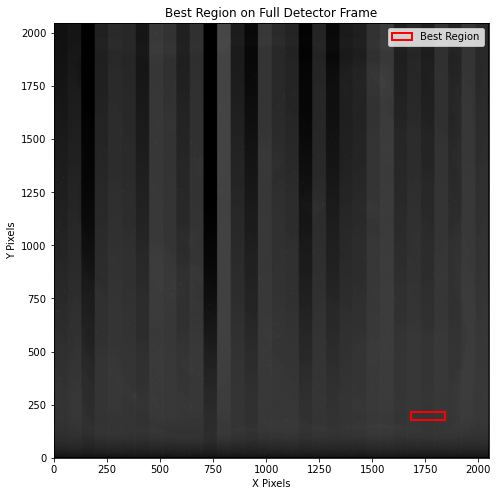

Best region coordinates: Start Row = 177, Start Column = 1681
Region Dimensions: Width = 159, Height = 36


In [6]:
region_height=36
region_width=159

# Visualize the best region within the frame
visualize_best_region_on_full_frame(image_stack[0], best_region_start_row, best_region_start_col, region_height=36, region_width=159)
# Print the coordinates of the best region
print(f"Best region coordinates: Start Row = {best_region_start_row}, Start Column = {best_region_start_col}")
print(f"Region Dimensions: Width = {region_width}, Height = {region_height}")